<a href="https://colab.research.google.com/github/AceKinnn/Artificial-Intelligence/blob/main/NLP_(RF%2C_NB%2C_SVM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Library**

In [ ]:
!pip install mlxtend

In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from bs4 import BeautifulSoup

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
import nltk
import string
string.punctuation
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score

from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#**1. Exploratory Data Analysis (EDA)**

In [ ]:
# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://drive.google.com/file/d/1awNE0oEL30qxa50lKkzQmuQAgX6C5zEe/view?usp=drive_link

In [ ]:
# Load the data
path = "drive/My Drive/Binus/Semester 5/Data Mining/rotten_tomatoes_movie_reviews.csv"
df = pd.read_csv(path, encoding='utf-8')
df.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


In [ ]:
# Select Relevant Columns
df = df[["reviewText", "scoreSentiment"]]
df.describe()

,reviewText,scoreSentiment
count,1375738,1444963
unique,1359771,2
top,Parental Content Review,POSITIVE
freq,236,963799


In [ ]:
df.groupby("scoreSentiment").describe()

reviewText                                      
                    count  unique                      top freq
scoreSentiment                                                 
NEGATIVE           453228  447983  Parental Content Review  127
POSITIVE           922510  911926  Parental Content Review  109

In [ ]:
# Count the number of each labels
df.scoreSentiment.value_counts()

POSITIVE    963799
NEGATIVE    481164
Name: scoreSentiment, dtype: int64

In [ ]:
# Check if there's any null values
print(df.isna().any())
# Count amount of null values to check if it is possible to drop them
print(df.isna().sum())

reviewText         True
scoreSentiment    False
dtype: bool
reviewText        69225
scoreSentiment        0
dtype: int64


In [ ]:
# Drop Null Values
df.dropna(inplace=True)

# Confirm the null values have been deleted
print(df.isna().any())
print(df.isna().sum())

reviewText        False
scoreSentiment    False
dtype: bool
reviewText        0
scoreSentiment    0
dtype: int64


##1.1. Before Downsampling

In [ ]:
df['word_len'] = df['reviewText'].apply(lambda x : len(x))
df

,reviewText,scoreSentiment,word_len
0,Timed to be just long enough for most youngste...,POSITIVE,161
1,It doesn't matter if a movie costs 300 million...,NEGATIVE,164
2,The choreography is so precise and lifelike at...,POSITIVE,246
3,The film's out-of-touch attempts at humor may ...,NEGATIVE,127
4,Its clumsy determination is endearing and some...,POSITIVE,71
...,...,...,...
1444958,Solid but not totally sold&#44; Thor&#58; Ragn...,POSITIVE,102
1444959,Thor&#58; Love and Thunder is the most enterta...,POSITIVE,182
1444960,&quot;Thor&#58; Love and Thunder&quot; is a st...,POSITIVE,155
1444961,Across Taika Waititi&#8217;s film&#44; a war a...,NEGATIVE,110


In [ ]:
df['label'] = df['scoreSentiment'].apply(lambda x : 0 if x == "POSITIVE" else 1)
df

,reviewText,scoreSentiment,word_len,label
0,Timed to be just long enough for most youngste...,POSITIVE,161,0
1,It doesn't matter if a movie costs 300 million...,NEGATIVE,164,1
2,The choreography is so precise and lifelike at...,POSITIVE,246,0
3,The film's out-of-touch attempts at humor may ...,NEGATIVE,127,1
4,Its clumsy determination is endearing and some...,POSITIVE,71,0
...,...,...,...,...
1444958,Solid but not totally sold&#44; Thor&#58; Ragn...,POSITIVE,102,0
1444959,Thor&#58; Love and Thunder is the most enterta...,POSITIVE,182,0
1444960,&quot;Thor&#58; Love and Thunder&quot; is a st...,POSITIVE,155,0
1444961,Across Taika Waititi&#8217;s film&#44; a war a...,NEGATIVE,110,1


array([<Axes: title={'center': 'NEGATIVE'}>,
       <Axes: title={'center': 'POSITIVE'}>], dtype=object)

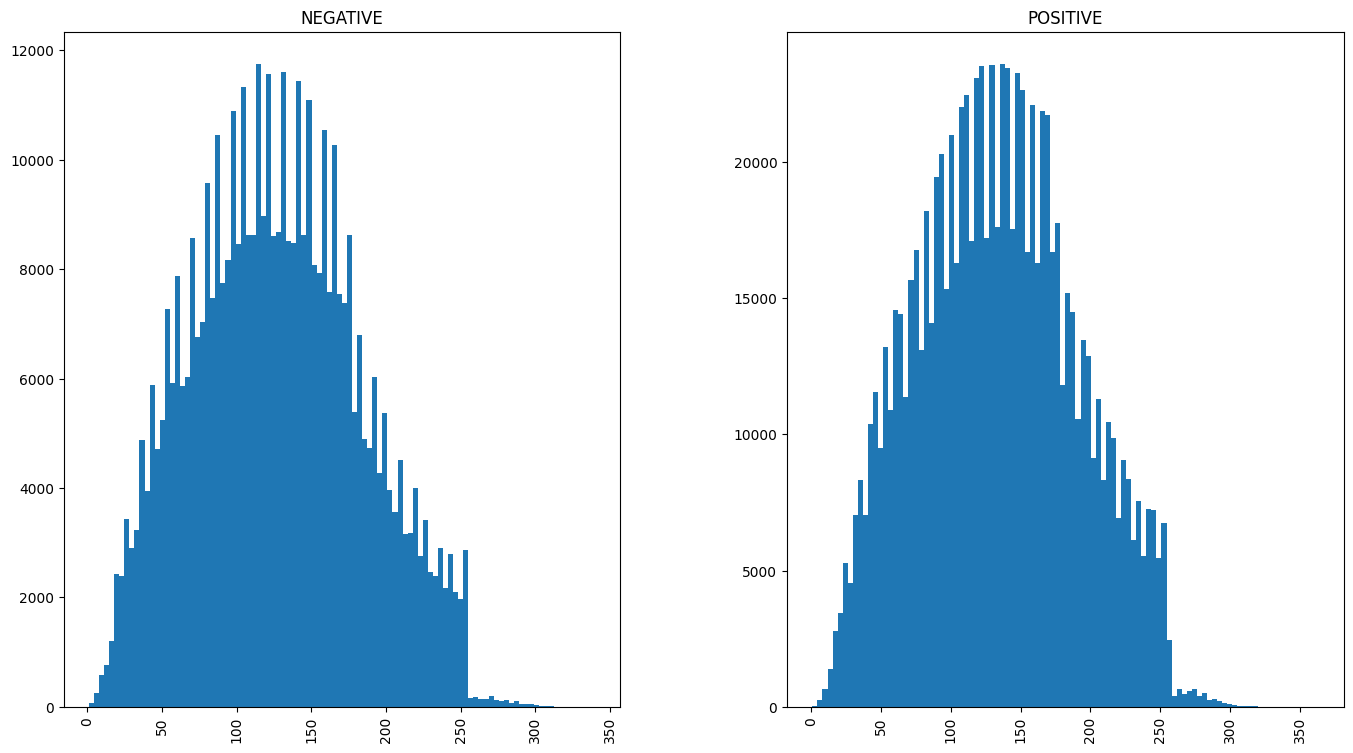

In [ ]:
df.hist(column='word_len',by='scoreSentiment',bins=100,figsize=(16,9))

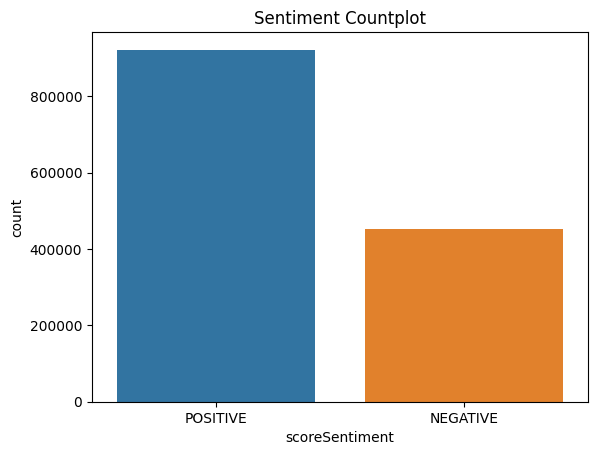

In [ ]:
# distribution of the data
sns.countplot(df, x='scoreSentiment')
plt.title('Sentiment Countplot')
plt.show()

In [ ]:
df_pos  = df[df['scoreSentiment'] == 'POSITIVE'].copy()
df_neg = df[df['scoreSentiment'] == 'NEGATIVE'].copy()

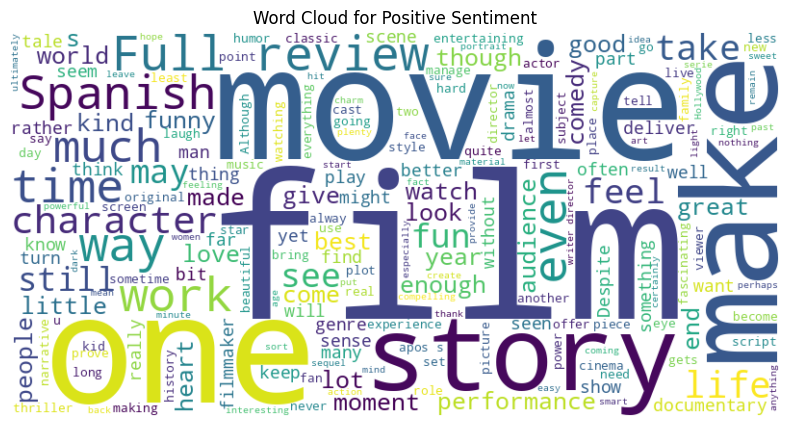

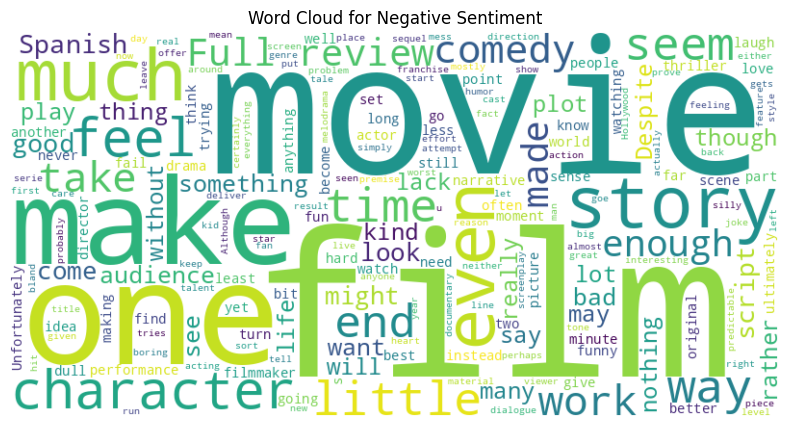

In [ ]:
# Generate word cloud for positive sentiment
positive_text = ' '.join(df_pos['reviewText'].values)
wordcloud_pos = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(positive_text)

# Display the word cloud for positive sentiment
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')
plt.show()

# Generate word cloud for negative sentiment
negative_text = ' '.join(df_neg['reviewText'].values)
wordcloud_neg = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(negative_text)

# Display the word cloud for negative sentiment
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')
plt.show()

##1.2. After Downsampling

In [ ]:
# Separate the majority and minority classes
data_majority = df[df['label'] == 0]
data_minority = df[df['label'] == 1]

desired_number = 10000
# Downsample the majority class to match the desired number of instances
data_majority_downsampled = resample(data_majority, replace=False, n_samples=desired_number, random_state=42)

# Downsample the minority class to match the desired number of instances
data_minority_downsampled = resample(data_minority, replace=False, n_samples=desired_number, random_state=42)

# Combine the downsampled majority and minority classes
data_downsampled = pd.concat([data_majority_downsampled, data_minority_downsampled])

# Shuffle the dataset (optional)
data_downsampled = data_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
new_class_distribution = data_downsampled['label'].value_counts()
df = data_downsampled

print("New Class Distribution:\n", new_class_distribution)

New Class Distribution:
 1    10000
0    10000
Name: label, dtype: int64


array([<Axes: title={'center': 'NEGATIVE'}>,
       <Axes: title={'center': 'POSITIVE'}>], dtype=object)

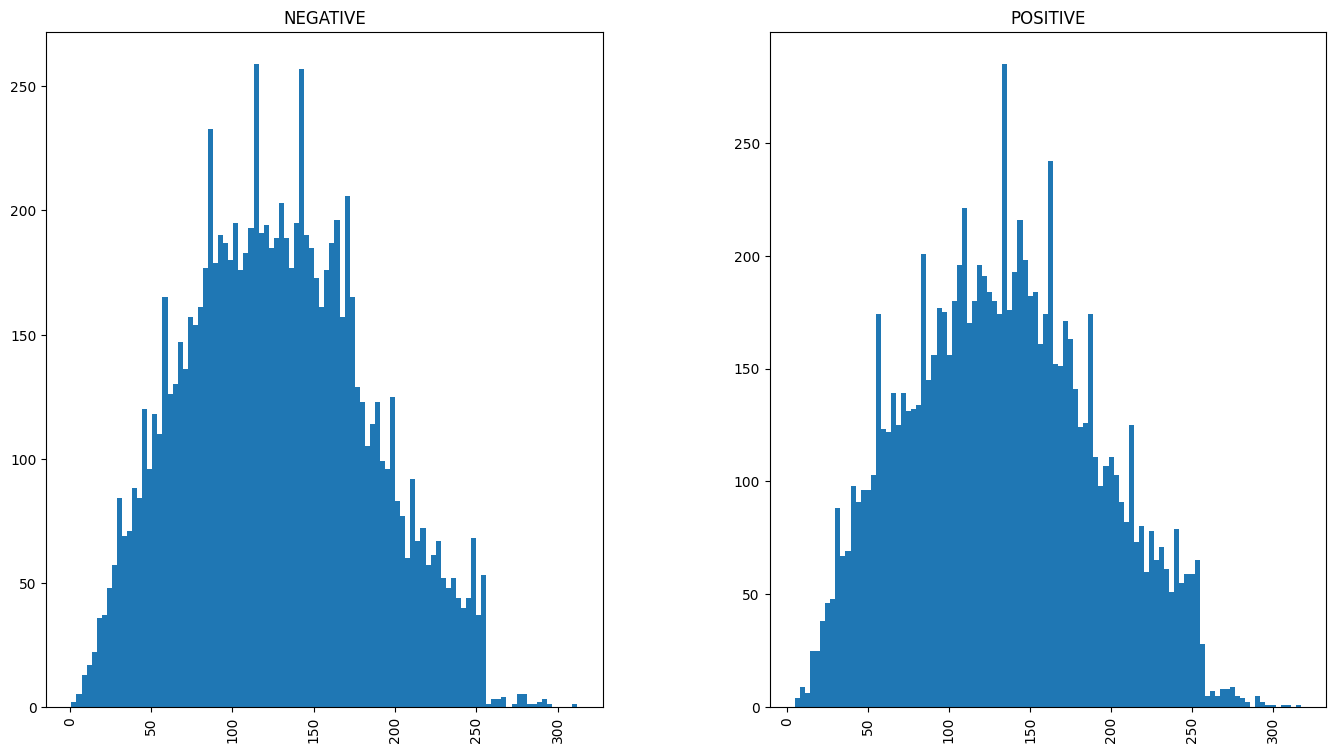

In [ ]:
df.hist(column='word_len',by='scoreSentiment',bins=100,figsize=(16,9))

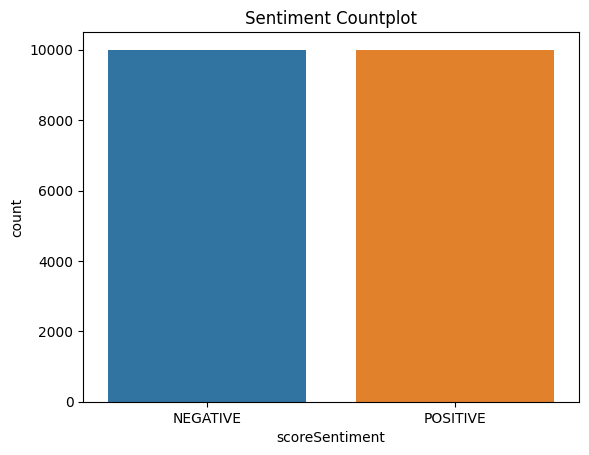

In [ ]:
sns.countplot(df,x='scoreSentiment')
plt.title('Sentiment Countplot')
plt.show()

In [ ]:
ddf_pos  = df[df['scoreSentiment'] == 'POSITIVE'].copy()
ddf_neg = df[df['scoreSentiment'] == 'NEGATIVE'].copy()

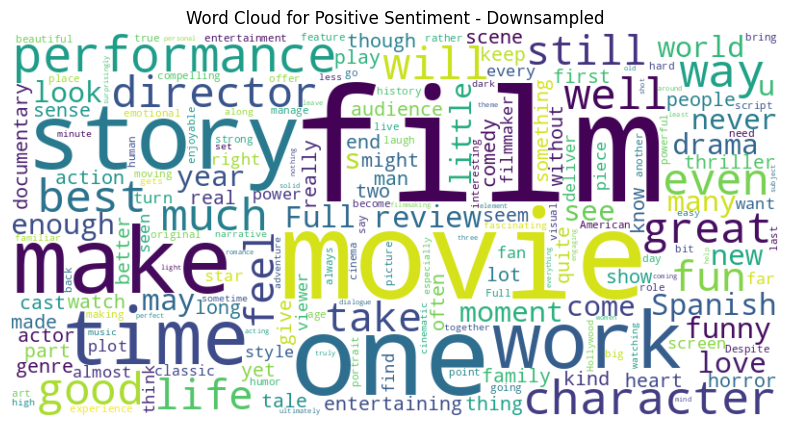

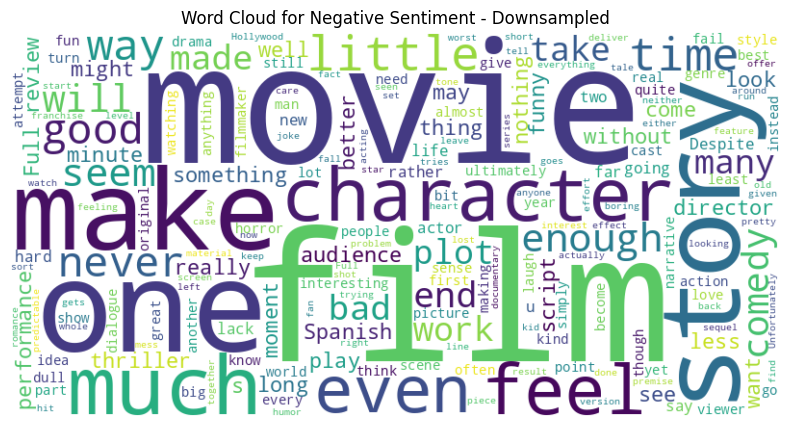

In [ ]:
positive_text_downsampled = ' '.join(ddf_pos['reviewText'].values)
wordcloud_pos_d = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(positive_text_downsampled)

# Display the word cloud for positive sentiment
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos_d, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment - Downsampled')
plt.axis('off')
plt.show()

# Generate word cloud for negative sentiment
negative_text_downsampled = ' '.join(ddf_neg['reviewText'].values)
wordcloud_neg_d = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(negative_text_downsampled)

# Display the word cloud for negative sentiment
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg_d, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment - Downsampled')
plt.axis('off')
plt.show()

#**Before Revised**
Data Splitting after BoW and TF-IDF

##2. Preprocessing

###2.1. Remove Punctuation and Stopwords

In [ ]:
def remove_punctuation_and_stopwords(text, custom_stopwords=None):
    # Remove punctuation
    text_no_punctuation = [ch for ch in text if ch not in string.punctuation]
    text_no_punctuation = "".join(text_no_punctuation).split()

    # Remove stopwords
    all_stopwords = set(stopwords.words("english"))
    if custom_stopwords:
        all_stopwords.update(custom_stopwords)

    text_no_stopwords = [word.lower() for word in text_no_punctuation if word.lower() not in all_stopwords]

    return text_no_stopwords

In [ ]:
df['reviewText'].apply(remove_punctuation_and_stopwords)

0        [uglydolls, really, ugly, terms, animation, qu...
1        [lesser, actors, involved, could, average, yet...
2        [fans, popular, series, delight, threequel, co...
3        [seoul, vibes, vibrant44, funny44, actionpacke...
4        [david, mamets, political, thriller, disappear...
                               ...                        
19995    [hitcher, uses, every, slasher, film, cliché, ...
19996    [de, de, pyaar, des, sense, humour, continues,...
19997    [dineens, receptive, gently, interrogative, st...
19998    [mystery, element, plot, less, engrossing, thi...
19999    [result, feels, like, cinematic, health, food,...
Name: reviewText, Length: 20000, dtype: object

###2.2. Visualization of Top 30 Words in Each Label

In [ ]:
# removing punctuation and stopword. Then stores the preprocessed text in two separate lists (words_data_pos and words_data_neg)
ddf_pos.loc[:, 'reviewText'] = ddf_pos['reviewText']
words_data_pos = ddf_pos['reviewText'].tolist()
ddf_neg.loc[:, 'reviewText'] = ddf_neg['reviewText']
words_data_neg = ddf_neg['reviewText'].tolist()

In [ ]:
list_pos_words = []
for sublist in words_data_pos:
    for item in sublist:
        list_pos_words.append(item)

In [ ]:
list_neg_words = []
for sublist in words_data_neg:
    for item in sublist:
        list_neg_words.append(item)

In [ ]:
fdist_pos  = nltk.FreqDist(list_pos_words)
fdist_neg = nltk.FreqDist(list_neg_words)

In [ ]:
df_poswords_top30  = pd.DataFrame(fdist_pos.most_common(30),  columns=['word', 'count'])
df_negwords_top30 = pd.DataFrame(fdist_neg.most_common(30), columns=['word', 'count'])

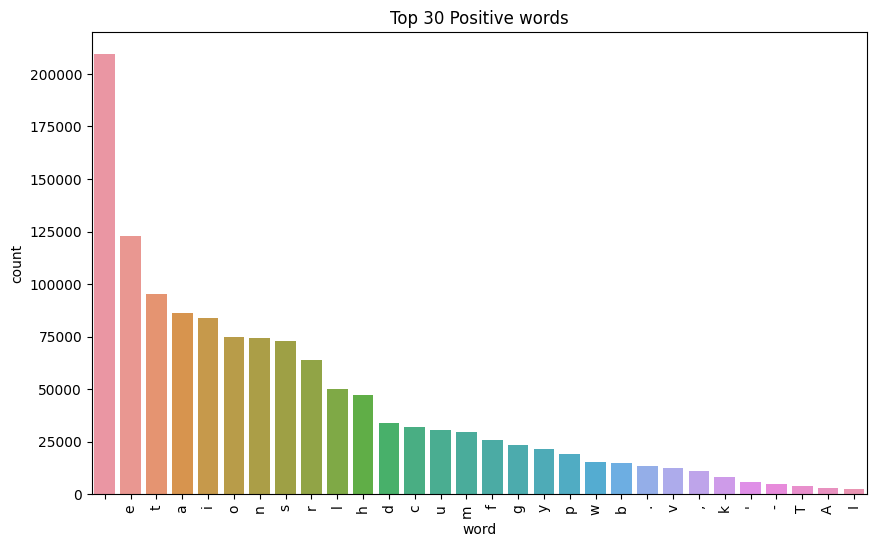

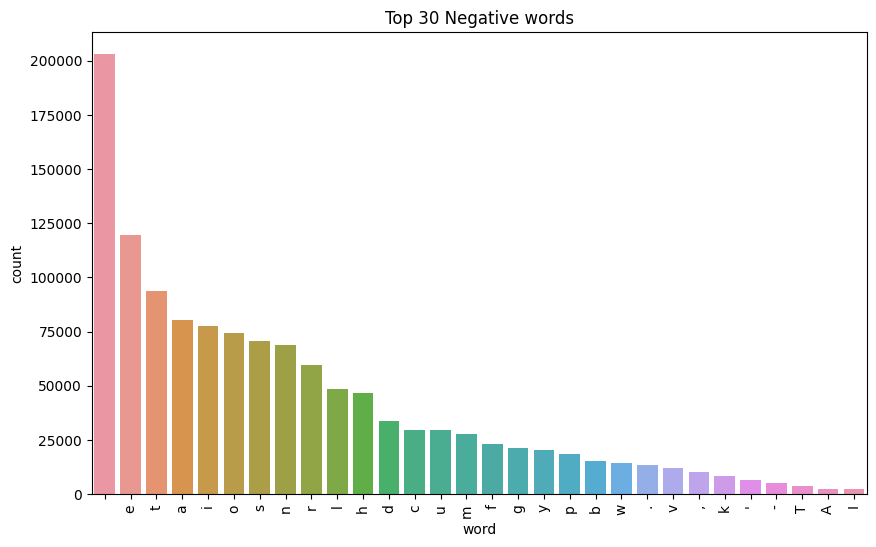

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count',
            data=df_poswords_top30, ax=ax)
plt.title("Top 30 Positive words")
plt.xticks(rotation='vertical');


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count',
            data=df_negwords_top30, ax=ax)
plt.title("Top 30 Negative words")
plt.xticks(rotation='vertical');

###2.3. Tokenization, Bag of Words, TF-IDF

In [ ]:
# Building the vocabulary
bow_transformer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(df['reviewText'])

# Size of the vocabulary that has learned
print(len(bow_transformer.vocabulary_))

# convert the text data in data['text'] into a Bag of Words (BoW) representation.
bow_data = bow_transformer.transform(df['reviewText'])

# finding the number of documents(rows) and unique terms(columns)
print("Number of documents and unique terms: ", bow_data.shape)

# find the count of non-zero elements in the matrix
print("Number of non-zero elements in the matrix: ", bow_data.nnz)

# Calculate the percentage of how sparse the matrix is
print("Sparsity of the matrix: ", bow_data.nnz / (bow_data.shape[0] * bow_data.shape[1]) *100 ,"%")

# Convert using tf-idf
tfidf_transformer = TfidfTransformer().fit(bow_data)
df_tfidf = tfidf_transformer.transform(bow_data)

35519
Number of documents and unique terms:  (20000, 35519)
Number of non-zero elements in the matrix:  243908
Sparsity of the matrix:  0.034334863031053806 %


###2.4. Split Data

In [ ]:
# Split the data into training and testing sets
df_tfidf_train, df_tfidf_test, label_train, label_test = train_test_split(df_tfidf, df["label"], test_size=0.2, random_state=42)

##3. Classification

### 3. 1. Random Forest

####Before Tuning

In [ ]:
# Create and train the Random Forest model
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(df_tfidf_train, label_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions on the training and testing set
rf_train_prediction = random_forest_classifier.predict(df_tfidf_train)
rf_test_prediction = random_forest_classifier.predict(df_tfidf_test)

In [ ]:
# Accuracy scores
rf_train_accuracy = accuracy_score(label_train, rf_train_prediction)*100
rf_test_accuracy = accuracy_score(label_test, rf_test_prediction)*100

# Confusion matrix and classification report
rf_conf_matrix = confusion_matrix(label_test, rf_test_prediction)
rf_classification_rep = classification_report(label_test, rf_test_prediction)

# Print results
print(f"Random Forest Training Accuracy: {rf_train_accuracy:.4f}%")
print(f"Random Forest Testing Accuracy: {rf_test_accuracy:.4f}%")
print("------------------------------")
print("Random Forest Confusion Matrix:\n", rf_conf_matrix)
print("Random Forest Classification Report:\n", rf_classification_rep)

Random Forest Training Accuracy: 99.9750%
Random Forest Testing Accuracy: 69.9000%
------------------------------
Random Forest Confusion Matrix:
 [[1315  740]
 [ 464 1481]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.64      0.69      2055
           1       0.67      0.76      0.71      1945

    accuracy                           0.70      4000
   macro avg       0.70      0.70      0.70      4000
weighted avg       0.70      0.70      0.70      4000



####After Tuning

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}

# Create GridSearchCV object
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_rf.fit(df_tfidf_train, label_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_rf.best_params_)

Best Parameters: {'max_depth': None, 'n_estimators': 150}


In [ ]:
random_forest_classifier_tuned = RandomForestClassifier(n_estimators=grid_rf.best_params_['n_estimators'],
                                                        max_depth=grid_rf.best_params_['max_depth'],)
random_forest_classifier_tuned.fit(df_tfidf_train, label_train)

RandomForestClassifier(n_estimators=150)

In [ ]:
# Predictions on the training and testing set
rf_train_prediction_tuned = random_forest_classifier_tuned.predict(df_tfidf_train)
rf_test_prediction_tuned = random_forest_classifier_tuned.predict(df_tfidf_test)

In [ ]:
# Accuracy scores
rf_train_accuracy_tuned = accuracy_score(label_train, rf_train_prediction_tuned)*100
rf_test_accuracy_tuned = accuracy_score(label_test, rf_test_prediction_tuned)*100

# Confusion matrix and classification report
rf_conf_matrix_tuned = confusion_matrix(label_test, rf_test_prediction_tuned)
rf_classification_rep_tuned = classification_report(label_test, rf_test_prediction_tuned)

# Print results
print(f"Random Forest Training Accuracy: {rf_train_accuracy_tuned:.4f}%")
print(f"Random Forest Testing Accuracy: {rf_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Random Forest Confusion Matrix:\n", rf_conf_matrix_tuned)
print("Random Forest Classification Report:\n", rf_classification_rep_tuned)

Random Forest Training Accuracy: 99.9750%
Random Forest Testing Accuracy: 69.6000%
------------------------------
Random Forest Confusion Matrix:
 [[1287  768]
 [ 448 1497]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.63      0.68      2055
           1       0.66      0.77      0.71      1945

    accuracy                           0.70      4000
   macro avg       0.70      0.70      0.70      4000
weighted avg       0.70      0.70      0.69      4000



### 3. 2. Naive Bayes Classification

####Before Tuning

In [ ]:
df_tfidf_train_nb = df_tfidf_train.A
df_tfidf_test_nb = df_tfidf_test.A

In [ ]:
naive_bayes_classifier = MultinomialNB().fit(df_tfidf_train_nb, label_train)
nb_test_prediction = naive_bayes_classifier.predict(df_tfidf_test_nb)
nb_train_prediction = naive_bayes_classifier.predict(df_tfidf_train_nb)

In [ ]:
nb_train_accuracy = accuracy_score(label_train, nb_train_prediction)*100
nb_test_accuracy = accuracy_score(label_test, nb_test_prediction)*100

nb_conf_matrix = confusion_matrix(label_test, nb_test_prediction)
nb_classification_rep = classification_report(label_test, nb_test_prediction)

print(f"Training Accuracy: {nb_train_accuracy:.4f}%")
print(f"Testing Accuracy: {nb_test_accuracy:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", nb_conf_matrix)
print("Classification Report:\n", nb_classification_rep)

Training Accuracy: 91.7500%
Testing Accuracy: 75.6000%
------------------------------
Confusion Matrix:
 [[1523  532]
 [ 444 1501]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76      2055
           1       0.74      0.77      0.75      1945

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



####After Tuning

In [ ]:
# Define the hyperparameter grid
param_grid_nb = {'alpha': [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]}

# Create the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

# Perform grid search with cross-validation
grid_nb= GridSearchCV(naive_bayes_classifier, param_grid_nb, cv=5, scoring='accuracy')
grid_nb.fit(df_tfidf_train, label_train)

# Get the best hyperparameter values
best_alpha = grid_nb.best_params_['alpha']

print(f"Best Aplha: {best_alpha}")

Best Aplha: 2.0


In [ ]:
naive_bayes_classifier_tuned = MultinomialNB(alpha=best_alpha).fit(df_tfidf_train, label_train)

nb_test_predictions_tuned = naive_bayes_classifier_tuned.predict(df_tfidf_test)
nb_train_prediction_tuned = naive_bayes_classifier_tuned.predict(df_tfidf_train)

In [ ]:
nb_train_accuracy_tuned = accuracy_score(label_train, nb_train_prediction_tuned)*100
nb_test_accuracy_tuned = accuracy_score(label_test, nb_test_predictions_tuned)*100

nb_conf_matrix_tuned = confusion_matrix(label_test, nb_test_predictions_tuned)
nb_classification_rep_tuned = classification_report(label_test, nb_test_predictions_tuned)

print(f"Tuned Training Accuracy: {nb_train_accuracy_tuned:.4f}%")
print(f"Tuned Testing Accuracy: {nb_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Tuned_Confusion Matrix:\n", nb_conf_matrix_tuned)
print("Tuned_Classification Report:\n", nb_classification_rep_tuned)

Tuned Training Accuracy: 89.9937%
Tuned Testing Accuracy: 75.9000%
------------------------------
Tuned_Confusion Matrix:
 [[1525  530]
 [ 434 1511]]
Tuned_Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76      2055
           1       0.74      0.78      0.76      1945

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [ ]:
# Get the feature names from the CountVectorizer
feature_names = bow_transformer.get_feature_names_out()

# Get the log probabilities of features
log_probabilities = naive_bayes_classifier_tuned.feature_log_prob_[1]  # Assuming class 1 corresponds to 'spam'

# Create a DataFrame with feature names and their log probabilities
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Log Probability': log_probabilities})

# Sort the DataFrame by log probabilities to get the most important features
feature_importance_df = feature_importance_df.sort_values(by='Log Probability', ascending=False)

# Print the top N important features
top_n = 10  # Change this to the desired number of top features
print(f"Top {top_n} Important Features:")
print(feature_importance_df.head(top_n))

Top 10 Important Features:
      Feature  Log Probability
20552   movie        -6.568153
11633    film        -6.600042
18190    like        -6.896688
20613    much        -7.092759
21899     one        -7.098153
29978   story        -7.241329
18322  little        -7.383756
21161   never        -7.446662
10608    even        -7.447760
13328    good        -7.487650


### 3. 3. Support Vector Machine

####Before Tuning

In [ ]:
# Create and train the SVM model
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(df_tfidf_train, label_train)

SVC()

In [ ]:
svm_train_prediction = svm_classifier.predict(df_tfidf_train)
svm_test_prediction = svm_classifier.predict(df_tfidf_test)

In [ ]:
svm_train_accuracy = accuracy_score(label_train, svm_train_prediction)*100
svm_test_accuracy = accuracy_score(label_test, svm_test_prediction)*100

svm_conf_matrix = confusion_matrix(label_test, svm_test_prediction)
svm_classification_rep = classification_report(label_test, svm_test_prediction)

print(f"Training Accuracy: {svm_train_accuracy:.4f}%")
print(f"Testing Accuracy: {svm_test_accuracy:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", svm_conf_matrix)
print("Classification Report:\n", svm_classification_rep)

Training Accuracy: 98.8875%
Testing Accuracy: 75.2750%
------------------------------
Confusion Matrix:
 [[1485  570]
 [ 419 1526]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75      2055
           1       0.73      0.78      0.76      1945

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



####After Tuning

In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10],           # Regularization parameter
    'kernel': ['linear', 'rbf', 'sigmoid'], # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
}

# Create GridSearchCV object
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_svm.fit(df_tfidf_train, label_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_svm.best_params_)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Train the model with the best hyperparameters
svm_classifier_tuned = SVC(C=grid_svm.best_params_['C'], kernel=grid_svm.best_params_['kernel'], gamma=grid_svm.best_params_['gamma'])
svm_classifier_tuned.fit(df_tfidf_train, label_train)

SVC(C=1)

In [ ]:
# Make predictions
svm_train_prediction_tuned = svm_classifier_tuned.predict(df_tfidf_train)
svm_test_predictions_tuned = svm_classifier_tuned.predict(df_tfidf_test)

In [ ]:
svm_train_accuracy_tuned = accuracy_score(label_train, svm_train_prediction_tuned) * 100
svm_test_accuracy_tuned = accuracy_score(label_test, svm_test_predictions_tuned) * 100

svm_conf_matrix_tuned = confusion_matrix(label_test, svm_test_predictions_tuned)
svm_classification_rep_tuned = classification_report(label_test, svm_test_predictions_tuned)

print(f"Training Accuracy: {svm_train_accuracy_tuned:.4f}%")
print(f"Testing Accuracy: {svm_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", svm_conf_matrix_tuned)
print("Classification Report:\n", svm_classification_rep_tuned)

Training Accuracy: 98.8875%
Testing Accuracy: 75.2750%
------------------------------
Confusion Matrix:
 [[1485  570]
 [ 419 1526]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75      2055
           1       0.73      0.78      0.76      1945

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



##4. Prediction

In [ ]:
# Example sentences
exp_zip = [
      'shout out to all of the casts',
      'The movie was soo great',
      'I know i never like it']

# convert the example text data into a Bag of Words (BoW) representation.
bow_data_exp_zip = bow_transformer.transform(exp_zip)
tfidf_transformer_exp_zip = TfidfTransformer().fit(bow_data_exp_zip)
tfidf_transformer_exp_zip = tfidf_transformer_exp_zip.transform(bow_data_exp_zip)

# Predict sentiments using Naive Bayes
nb_pred_zip = naive_bayes_classifier_tuned.predict(tfidf_transformer_exp_zip)

# Predict sentiments using Random Forest
rf_pred_zip = random_forest_classifier_tuned.predict(tfidf_transformer_exp_zip)

# Predict sentiments using SVM
svm_pred_zip = svm_classifier_tuned.predict(tfidf_transformer_exp_zip)

# Print the results
for text, nb_score, rf_score, svm_score in zip(exp_zip, nb_pred_zip, rf_pred_zip, svm_pred_zip):
    print(f"Input Text: {text}")
    print(f"NB Score: {'Positive' if nb_score == 0 else 'Negative'}")
    print(f"RF Score: {'Positive' if rf_score == 0 else 'Negative'}")
    print(f"SVM Score: {'Positive' if svm_score == 0 else 'Negative'}")
    print("------------------------")

NameError: ignored

In [ ]:
# Example sentences
exp = input("Enter a sentence for sentiment analysis: ")

# convert the example text data into a Bag of Words (BoW) representation.
bow_data_exp = bow_transformer.transform([exp])
tfidf_transformer_exp = TfidfTransformer().fit(bow_data_exp)
tfidf_transformer_exp = tfidf_transformer_exp.transform(bow_data_exp)

# Predict sentiments using Naive Bayes
nb_pred = naive_bayes_classifier_tuned.predict(tfidf_transformer_exp)

# Predict sentiments using Random Forest
rf_pred = random_forest_classifier.predict(tfidf_transformer_exp)

# Predict sentiments using SVM
svm_pred = svm_classifier.predict(tfidf_transformer_exp)

# Print the results
print(f"Input Text: {exp}")
print(f"NB Score: {'Positive' if nb_pred == 0 else 'Negative'}")
print(f"RF Score: {'Positive' if rf_pred == 0 else 'Negative'}")
print(f"SVM Score: {'Positive' if svm_pred == 0 else 'Negative'}")

Enter a sentence for sentiment analysis: Big Fish is a cinematic masterpiece, weaving a magical tapestry of storytelling and emotion that leaves you enchanted from beginning to end.
Input Text: Big Fish is a cinematic masterpiece, weaving a magical tapestry of storytelling and emotion that leaves you enchanted from beginning to end.
NB Score: Positive
RF Score: Negative
SVM Score: Negative


#**Original**
No Custom Stopwords, No HTML Parser, CV = 5

##2. Preprocessing

###2.1. Remove Punctuation and Stopwords

In [ ]:
def remove_punctuation_and_stopwords(text, custom_stopwords=None):
    # Remove punctuation
    text_no_punctuation = [ch for ch in text if ch not in string.punctuation]
    text_no_punctuation = "".join(text_no_punctuation).split()

    # Remove stopwords
    all_stopwords = set(stopwords.words("english"))
    if custom_stopwords:
        all_stopwords.update(custom_stopwords)

    text_no_stopwords = [word.lower() for word in text_no_punctuation if word.lower() not in all_stopwords]

    return text_no_stopwords

In [ ]:
df['reviewText'].apply(remove_punctuation_and_stopwords)

0        [uglydolls, really, ugly, terms, animation, qu...
1        [lesser, actors, involved, could, average, yet...
2        [fans, popular, series, delight, threequel, co...
3        [seoul, vibes, vibrant44, funny44, actionpacke...
4        [david, mamets, political, thriller, disappear...
                               ...                        
19995    [hitcher, uses, every, slasher, film, cliché, ...
19996    [de, de, pyaar, des, sense, humour, continues,...
19997    [dineens, receptive, gently, interrogative, st...
19998    [mystery, element, plot, less, engrossing, thi...
19999    [result, feels, like, cinematic, health, food,...
Name: reviewText, Length: 20000, dtype: object

###2.2. Visualization of Top 30 Words in Each Label

In [ ]:
# removing punctuation and stopword. Then stores the preprocessed text in two separate lists (words_data_pos and words_data_neg)
ddf_pos.loc[:, 'reviewText'] = ddf_pos['reviewText'].apply(remove_punctuation_and_stopwords)
words_data_pos = ddf_pos['reviewText'].tolist()
ddf_neg.loc[:, 'reviewText'] = ddf_neg['reviewText'].apply(remove_punctuation_and_stopwords)
words_data_neg = ddf_neg['reviewText'].tolist()

In [ ]:
list_pos_words = []
for sublist in words_data_pos:
    for item in sublist:
        list_pos_words.append(item)

In [ ]:
list_neg_words = []
for sublist in words_data_neg:
    for item in sublist:
        list_neg_words.append(item)

In [ ]:
fdist_pos  = nltk.FreqDist(list_pos_words)
fdist_neg = nltk.FreqDist(list_neg_words)

In [ ]:
df_poswords_top30  = pd.DataFrame(fdist_pos.most_common(30),  columns=['word', 'count'])
df_negwords_top30 = pd.DataFrame(fdist_neg.most_common(30), columns=['word', 'count'])

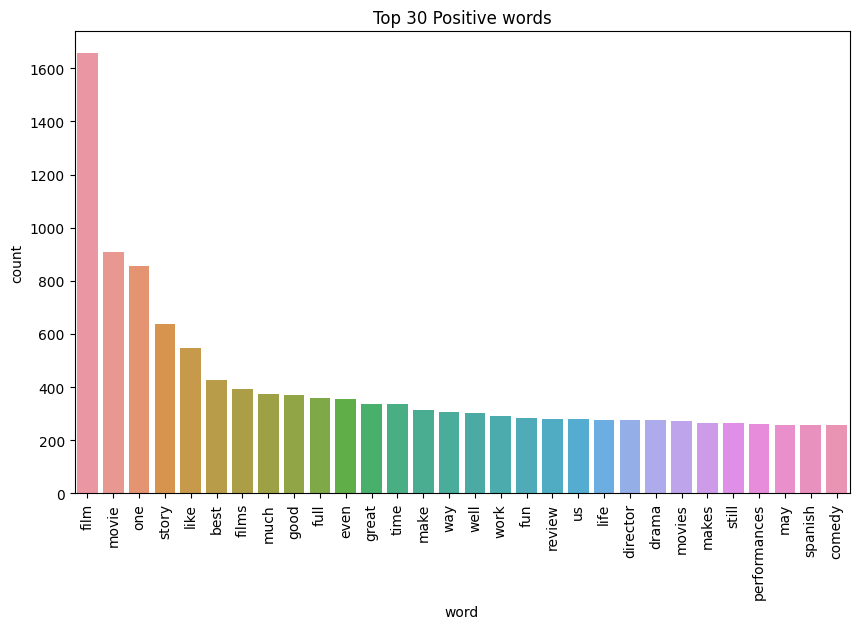

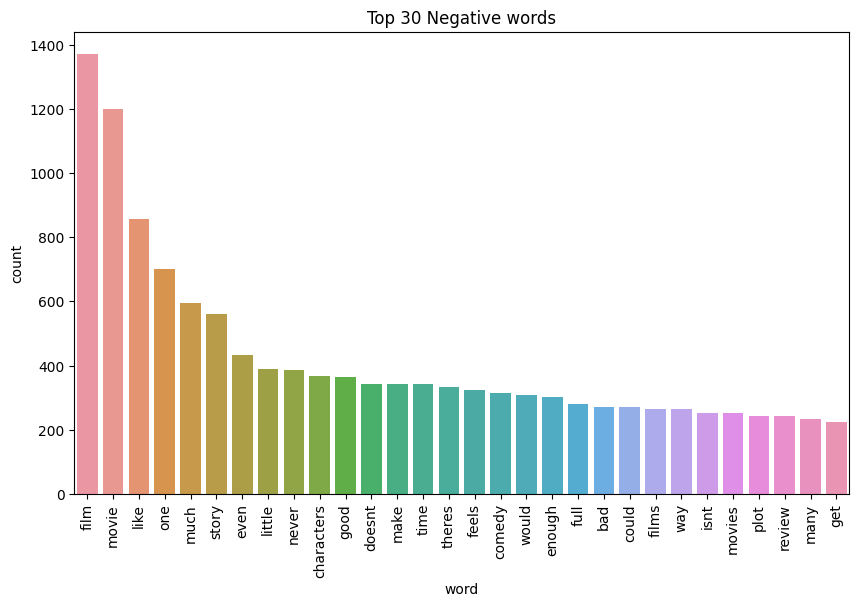

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count',
            data=df_poswords_top30, ax=ax)
plt.title("Top 30 Positive words")
plt.xticks(rotation='vertical');


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count',
            data=df_negwords_top30, ax=ax)
plt.title("Top 30 Negative words")
plt.xticks(rotation='vertical');

###2.3. Split Data

In [ ]:
# Split the data into training and testing sets
train_df, test_df, label_train, label_test = train_test_split(df['reviewText'], df['label'], test_size=0.2, random_state=42)

###2.4. Tokenization, Bag of Words, TF-IDF

In [ ]:
# Building the vocabulary on the training set
bow_transformer = CountVectorizer(analyzer=remove_punctuation_and_stopwords).fit(train_df)

# Size of the vocabulary that has learned
print(len(bow_transformer.vocabulary_))

# Convert the text data in the training set into a Bag of Words (BoW) representation
bow_train_data = bow_transformer.transform(train_df)

# Finding the number of documents (rows) and unique terms (columns) in the training set
print("Number of training documents and unique terms: ", bow_train_data.shape)

# Convert the text data in the testing set into a Bag of Words (BoW) representation
bow_test_data = bow_transformer.transform(test_df)

# Finding the number of documents (rows) and unique terms (columns) in the testing set
print("Number of testing documents and unique terms: ", bow_test_data.shape)

31643
Number of training documents and unique terms:  (16000, 31643)
Number of testing documents and unique terms:  (4000, 31643)


In [ ]:
# Convert using tf-idf on the training set
tfidf_transformer = TfidfTransformer().fit(bow_train_data)
tfidf_train_data = tfidf_transformer.transform(bow_train_data)

# Convert using tf-idf on the testing set
tfidf_test_data = tfidf_transformer.transform(bow_test_data)

In [ ]:
# finding the number of documents(rows) and unique terms(columns)
print("Number of documents and unique terms in training data: ", tfidf_train_data.shape)

# Finding the number of documents (rows) and unique terms (columns) in test data
print("Number of documents and unique terms in test data: ", tfidf_test_data.shape)

# find the count of non-zero elements in the matrix
print("Number of non-zero elements in the train matrix: ", tfidf_train_data.nnz)

# find the count of non-zero elements in the matrix in test data
print("Number of non-zero elements in the test matrix: ", tfidf_test_data.nnz)

# Calculate the percentage of how sparse the matrix is
print("Sparsity of the train matrix: ", tfidf_train_data.nnz / (tfidf_train_data.shape[0] * tfidf_train_data.shape[1]) *100 ,"%")

# Calculate the percentage of how sparse the matrix is in test data
print("Sparsity of the test matrix: ", tfidf_test_data.nnz / (tfidf_test_data.shape[0] * tfidf_test_data.shape[1]) *100 ,"%")

Number of documents and unique terms in training data:  (16000, 31643)
Number of documents and unique terms in test data:  (4000, 31643)
Number of non-zero elements in the train matrix:  195323
Number of non-zero elements in the test matrix:  44473
Sparsity of the train matrix:  0.038579425149322125 %
Sparsity of the test matrix:  0.03513652308567456 %


##3. Classification

### 3. 1. Random Forest

####Before Tuning

In [ ]:
# Create and train the Random Forest model
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(tfidf_train_data, label_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions on the training and testing set
rf_train_prediction = random_forest_classifier.predict(tfidf_train_data)
rf_test_prediction = random_forest_classifier.predict(tfidf_test_data)

In [ ]:
# Accuracy scores
rf_train_accuracy = accuracy_score(label_train, rf_train_prediction)*100
rf_test_accuracy = accuracy_score(label_test, rf_test_prediction)*100

# Confusion matrix and classification report
rf_conf_matrix = confusion_matrix(label_test, rf_test_prediction)
rf_classification_rep = classification_report(label_test, rf_test_prediction)

# Print results
print(f"Random Forest Training Accuracy: {rf_train_accuracy:.4f}%")
print(f"Random Forest Testing Accuracy: {rf_test_accuracy:.4f}%")
print("------------------------------")
print("Random Forest Confusion Matrix:\n", rf_conf_matrix)
print("Random Forest Classification Report:\n", rf_classification_rep)

Random Forest Training Accuracy: 99.9750%
Random Forest Testing Accuracy: 70.3500%
------------------------------
Random Forest Confusion Matrix:
 [[1334  721]
 [ 465 1480]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.65      0.69      2055
           1       0.67      0.76      0.71      1945

    accuracy                           0.70      4000
   macro avg       0.71      0.71      0.70      4000
weighted avg       0.71      0.70      0.70      4000



####After Tuning

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}

# Create GridSearchCV object
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_rf.fit(tfidf_train_data, label_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_rf.best_params_)

Best Parameters: {'max_depth': None, 'n_estimators': 150}


In [ ]:
random_forest_classifier_tuned = RandomForestClassifier(n_estimators=grid_rf.best_params_['n_estimators'],
                                                        max_depth=grid_rf.best_params_['max_depth'],)
random_forest_classifier_tuned.fit(tfidf_train_data, label_train)

RandomForestClassifier(n_estimators=150)

In [ ]:
# Predictions on the training and testing set
rf_train_prediction_tuned = random_forest_classifier_tuned.predict(tfidf_train_data)
rf_test_prediction_tuned = random_forest_classifier_tuned.predict(tfidf_test_data)

In [ ]:
# Accuracy scores
rf_train_accuracy_tuned = accuracy_score(label_train, rf_train_prediction_tuned)*100
rf_test_accuracy_tuned = accuracy_score(label_test, rf_test_prediction_tuned)*100

# Confusion matrix and classification report
rf_conf_matrix_tuned = confusion_matrix(label_test, rf_test_prediction_tuned)
rf_classification_rep_tuned = classification_report(label_test, rf_test_prediction_tuned)

# Print results
print(f"Random Forest Training Accuracy: {rf_train_accuracy_tuned:.4f}%")
print(f"Random Forest Testing Accuracy: {rf_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Random Forest Confusion Matrix:\n", rf_conf_matrix_tuned)
print("Random Forest Classification Report:\n", rf_classification_rep_tuned)

Random Forest Training Accuracy: 99.9750%
Random Forest Testing Accuracy: 70.7500%
------------------------------
Random Forest Confusion Matrix:
 [[1339  716]
 [ 454 1491]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.70      2055
           1       0.68      0.77      0.72      1945

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000



### 3. 2. Naive Bayes Classification

####Before Tuning

In [ ]:
df_tfidf_train_nb = tfidf_train_data.A
df_tfidf_test_nb = tfidf_test_data.A

In [ ]:
naive_bayes_classifier = MultinomialNB().fit(df_tfidf_train_nb, label_train)
nb_test_prediction = naive_bayes_classifier.predict(df_tfidf_test_nb)
nb_train_prediction = naive_bayes_classifier.predict(df_tfidf_train_nb)

In [ ]:
nb_train_accuracy = accuracy_score(label_train, nb_train_prediction)*100
nb_test_accuracy = accuracy_score(label_test, nb_test_prediction)*100

nb_conf_matrix = confusion_matrix(label_test, nb_test_prediction)
nb_classification_rep = classification_report(label_test, nb_test_prediction)

print(f"Training Accuracy: {nb_train_accuracy:.4f}%")
print(f"Testing Accuracy: {nb_test_accuracy:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", nb_conf_matrix)
print("Classification Report:\n", nb_classification_rep)

Training Accuracy: 91.7125%
Testing Accuracy: 75.6000%
------------------------------
Confusion Matrix:
 [[1525  530]
 [ 446 1499]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76      2055
           1       0.74      0.77      0.75      1945

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



####After Tuning

In [ ]:
# Define the hyperparameter grid
param_grid_nb = {'alpha': [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]}

# Create the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

# Perform grid search with cross-validation
grid_nb= GridSearchCV(naive_bayes_classifier, param_grid_nb, cv=5, scoring='accuracy')
grid_nb.fit(tfidf_train_data, label_train)

# Get the best hyperparameter values
best_alpha = grid_nb.best_params_['alpha']

print(f"Best Aplha: {best_alpha}")

Best Aplha: 3.0


In [ ]:
naive_bayes_classifier_tuned = MultinomialNB(alpha=best_alpha).fit(tfidf_train_data, label_train)

nb_test_predictions_tuned = naive_bayes_classifier_tuned.predict(tfidf_test_data)
nb_train_prediction_tuned = naive_bayes_classifier_tuned.predict(tfidf_train_data)

In [ ]:
nb_train_accuracy_tuned = accuracy_score(label_train, nb_train_prediction_tuned)*100
nb_test_accuracy_tuned = accuracy_score(label_test, nb_test_predictions_tuned)*100

nb_conf_matrix_tuned = confusion_matrix(label_test, nb_test_predictions_tuned)
nb_classification_rep_tuned = classification_report(label_test, nb_test_predictions_tuned)

print(f"Tuned Training Accuracy: {nb_train_accuracy_tuned:.4f}%")
print(f"Tuned Testing Accuracy: {nb_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Tuned_Confusion Matrix:\n", nb_conf_matrix_tuned)
print("Tuned_Classification Report:\n", nb_classification_rep_tuned)

Tuned Training Accuracy: 88.5812%
Tuned Testing Accuracy: 75.9250%
------------------------------
Tuned_Confusion Matrix:
 [[1523  532]
 [ 431 1514]]
Tuned_Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76      2055
           1       0.74      0.78      0.76      1945

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [ ]:
# Get the feature names from the CountVectorizer
feature_names = bow_transformer.get_feature_names_out()

# Get the log probabilities of features
log_probabilities = naive_bayes_classifier_tuned.feature_log_prob_[1]  # Assuming class 1 corresponds to 'spam'

# Create a DataFrame with feature names and their log probabilities
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Log Probability': log_probabilities})

# Sort the DataFrame by log probabilities to get the most important features
feature_importance_df = feature_importance_df.sort_values(by='Log Probability', ascending=False)

# Print the top N important features
top_n = 10  # Change this to the desired number of top features
print(f"Top {top_n} Important Features:")
print(feature_importance_df.head(top_n))

Top 10 Important Features:
      Feature  Log Probability
18314   movie        -6.770287
10397    film        -6.805229
16224    like        -7.098053
18371    much        -7.293660
19504     one        -7.295400
26700   story        -7.443774
16339  little        -7.585112
18854   never        -7.643217
9483     even        -7.645080
11889    good        -7.675951


### 3. 3. Support Vector Machine

####Before Tuning

In [ ]:
# Create and train the SVM model
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(tfidf_train_data, label_train)

SVC()

In [ ]:
svm_train_prediction = svm_classifier.predict(tfidf_train_data)
svm_test_prediction = svm_classifier.predict(tfidf_test_data)

In [ ]:
svm_train_accuracy = accuracy_score(label_train, svm_train_prediction)*100
svm_test_accuracy = accuracy_score(label_test, svm_test_prediction)*100

svm_conf_matrix = confusion_matrix(label_test, svm_test_prediction)
svm_classification_rep = classification_report(label_test, svm_test_prediction)

print(f"Training Accuracy: {svm_train_accuracy:.4f}%")
print(f"Testing Accuracy: {svm_test_accuracy:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", svm_conf_matrix)
print("Classification Report:\n", svm_classification_rep)

Training Accuracy: 98.8875%
Testing Accuracy: 75.2250%
------------------------------
Confusion Matrix:
 [[1497  558]
 [ 433 1512]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75      2055
           1       0.73      0.78      0.75      1945

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



####After Tuning

In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10],           # Regularization parameter
    'kernel': ['linear', 'rbf', 'sigmoid'], # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
}

# Create GridSearchCV object
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_svm.fit(tfidf_train_data, label_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_svm.best_params_)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Train the model with the best hyperparameters
svm_classifier_tuned = SVC(C=grid_svm.best_params_['C'], kernel=grid_svm.best_params_['kernel'], gamma=grid_svm.best_params_['gamma'])
svm_classifier_tuned.fit(tfidf_train_data, label_train)

SVC(C=1)

In [ ]:
# Make predictions
svm_train_prediction_tuned = svm_classifier_tuned.predict(tfidf_train_data)
svm_test_predictions_tuned = svm_classifier_tuned.predict(tfidf_test_data)

In [ ]:
svm_train_accuracy_tuned = accuracy_score(label_train, svm_train_prediction_tuned) * 100
svm_test_accuracy_tuned = accuracy_score(label_test, svm_test_predictions_tuned) * 100

svm_conf_matrix_tuned = confusion_matrix(label_test, svm_test_predictions_tuned)
svm_classification_rep_tuned = classification_report(label_test, svm_test_predictions_tuned)

print(f"Training Accuracy: {svm_train_accuracy_tuned:.4f}%")
print(f"Testing Accuracy: {svm_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", svm_conf_matrix_tuned)
print("Classification Report:\n", svm_classification_rep_tuned)

Training Accuracy: 98.8875%
Testing Accuracy: 75.2250%
------------------------------
Confusion Matrix:
 [[1497  558]
 [ 433 1512]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75      2055
           1       0.73      0.78      0.75      1945

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



##4. Prediction

In [ ]:
# Example sentences
exp_zip = [
      'shout out to all of the casts',
      'The movie was soo great',
      'I know i never like it']

# convert the example text data into a Bag of Words (BoW) representation.
bow_data_exp_zip = bow_transformer.transform(exp_zip)
tfidf_transformer_exp_zip = TfidfTransformer().fit(bow_data_exp_zip)
tfidf_transformer_exp_zip = tfidf_transformer_exp_zip.transform(bow_data_exp_zip)

# Predict sentiments using Naive Bayes
nb_pred_zip = naive_bayes_classifier_tuned.predict(tfidf_transformer_exp_zip)

# Predict sentiments using Random Forest
rf_pred_zip = random_forest_classifier.predict(tfidf_transformer_exp_zip)

# Predict sentiments using SVM
svm_pred_zip = svm_classifier.predict(tfidf_transformer_exp_zip)

# Print the results
for text, nb_score, rf_score, svm_score in zip(exp_zip, nb_pred_zip, rf_pred_zip, svm_pred_zip):
    print(f"Input Text: {text}")
    print(f"NB Score: {'Positive' if nb_score == 0 else 'Negative'}")
    print(f"RF Score: {'Positive' if rf_score == 0 else 'Negative'}")
    print(f"SVM Score: {'Positive' if svm_score == 0 else 'Negative'}")
    print("------------------------")

Input Text: shout out to all of the casts
NB Score: Positive
RF Score: Negative
SVM Score: Negative
------------------------
Input Text: The movie was soo great
NB Score: Positive
RF Score: Positive
SVM Score: Positive
------------------------
Input Text: I know i never like it
NB Score: Negative
RF Score: Negative
SVM Score: Negative
------------------------


In [ ]:
# Example sentences
exp = input("Enter a sentence for sentiment analysis: ")

# convert the example text data into a Bag of Words (BoW) representation.
bow_data_exp = bow_transformer.transform([exp])
tfidf_transformer_exp = TfidfTransformer().fit(bow_data_exp)
tfidf_transformer_exp = tfidf_transformer_exp.transform(bow_data_exp)

# Predict sentiments using Naive Bayes
nb_pred = naive_bayes_classifier_tuned.predict(tfidf_transformer_exp)

# Predict sentiments using Random Forest
rf_pred = random_forest_classifier.predict(tfidf_transformer_exp)

# Predict sentiments using SVM
svm_pred = svm_classifier.predict(tfidf_transformer_exp)

# Print the results
print(f"Input Text: {exp}")
print(f"NB Score: {'Positive' if nb_pred == 0 else 'Negative'}")
print(f"RF Score: {'Positive' if rf_pred == 0 else 'Negative'}")
print(f"SVM Score: {'Positive' if svm_pred == 0 else 'Negative'}")

Enter a sentence for sentiment analysis: Big Fish is a cinematic masterpiece, weaving a magical tapestry of storytelling and emotion that leaves you enchanted from beginning to end.
Input Text: Big Fish is a cinematic masterpiece, weaving a magical tapestry of storytelling and emotion that leaves you enchanted from beginning to end.
NB Score: Positive
RF Score: Negative
SVM Score: Negative


#**Alternative 1**
With Custom Stopwords, With HTML Parser, CV = 5

##2. Preprocessing

###2.1. Remove Punctuation and Stopwords

In [ ]:
def remove_punctuation_and_stopwords(text, custom_stopwords=None):
    # Remove HTML tags
    text_no_html = BeautifulSoup(text, "html.parser").get_text()

    # Remove punctuation
    text_no_punctuation = [ch for ch in text_no_html if ch not in string.punctuation]
    text_no_punctuation = "".join(text_no_punctuation).split()

    # Remove stopwords
    all_stopwords = set(stopwords.words("english"))
    if custom_stopwords:
        all_stopwords.update(custom_stopwords)

    text_no_stopwords = [word.lower() for word in text_no_punctuation if word.lower() not in all_stopwords]

    return text_no_stopwords

In [ ]:
# Utilization of custom stopwords
custom_stopwords = ['film', 'movie']

In [ ]:
print(df['reviewText'].apply(lambda x: remove_punctuation_and_stopwords(x, custom_stopwords)))

0        [uglydolls, really, ugly, terms, animation, qu...
1        [lesser, actors, involved, could, average, yet...
2        [fans, popular, series, delight, threequel, co...
3        [seoul, vibes, vibrant, funny, actionpacked, g...
4        [david, mamets, political, thriller, disappear...
                               ...                        
19995    [hitcher, uses, every, slasher, cliché, frustr...
19996    [de, de, pyaar, des, sense, humour, continues,...
19997    [dineens, receptive, gently, interrogative, st...
19998    [mystery, element, plot, less, engrossing, thi...
19999    [result, feels, like, cinematic, health, food,...
Name: reviewText, Length: 20000, dtype: object


###2.2. Visualization of Top 30 Words in Each Label

In [ ]:
# removing punctuation and stopword. Then stores the preprocessed text in two separate lists (words_data_pos and words_data_neg)
ddf_pos.loc[:, 'reviewText'] = ddf_pos['reviewText'].apply(lambda x: remove_punctuation_and_stopwords(x, custom_stopwords))
words_data_pos = ddf_pos['reviewText'].tolist()
ddf_neg.loc[:, 'reviewText'] = ddf_neg['reviewText'].apply(lambda x: remove_punctuation_and_stopwords(x, custom_stopwords))
words_data_neg = ddf_neg['reviewText'].tolist()

In [ ]:
list_pos_words = []
for sublist in words_data_pos:
    for item in sublist:
        list_pos_words.append(item)

In [ ]:
list_neg_words = []
for sublist in words_data_neg:
    for item in sublist:
        list_neg_words.append(item)

In [ ]:
fdist_pos  = nltk.FreqDist(list_pos_words)
fdist_neg = nltk.FreqDist(list_neg_words)

In [ ]:
df_poswords_top30  = pd.DataFrame(fdist_pos.most_common(30),  columns=['word', 'count'])
df_negwords_top30 = pd.DataFrame(fdist_neg.most_common(30), columns=['word', 'count'])

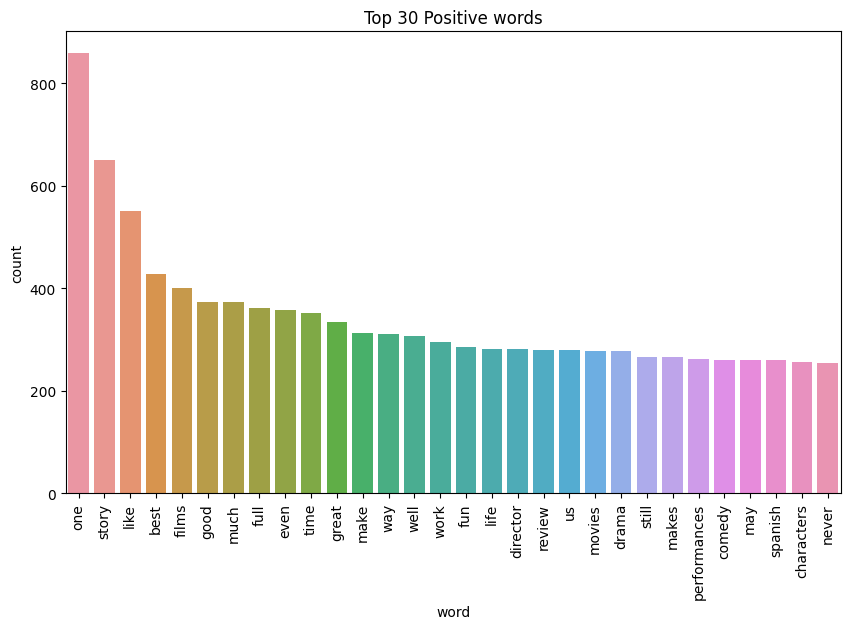

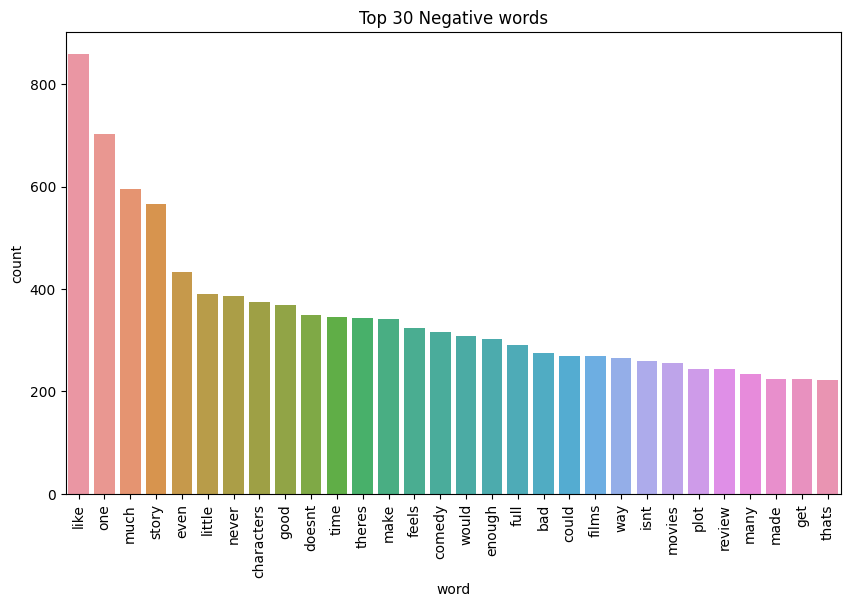

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count',
            data=df_poswords_top30, ax=ax)
plt.title("Top 30 Positive words")
plt.xticks(rotation='vertical');


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count',
            data=df_negwords_top30, ax=ax)
plt.title("Top 30 Negative words")
plt.xticks(rotation='vertical');

###2.3. Split Data

In [ ]:
# Split the data into training and testing sets
train_df, test_df, label_train, label_test = train_test_split(df['reviewText'], df['label'], test_size=0.2, random_state=42)

###2.4. Tokenization, Bag of Words, TF-IDF

In [ ]:
# Building the vocabulary on the training set
bow_transformer = CountVectorizer(analyzer=remove_punctuation_and_stopwords).fit(train_df)

# Size of the vocabulary that has learned
print(len(bow_transformer.vocabulary_))

# Convert the text data in the training set into a Bag of Words (BoW) representation
bow_train_data = bow_transformer.transform(train_df)

# Finding the number of documents (rows) and unique terms (columns) in the training set
print("Number of training documents and unique terms: ", bow_train_data.shape)

# Convert the text data in the testing set into a Bag of Words (BoW) representation
bow_test_data = bow_transformer.transform(test_df)

# Finding the number of documents (rows) and unique terms (columns) in the testing set
print("Number of testing documents and unique terms: ", bow_test_data.shape)

30380
Number of training documents and unique terms:  (16000, 30380)
Number of testing documents and unique terms:  (4000, 30380)


In [ ]:
# Convert using tf-idf on the training set
tfidf_transformer = TfidfTransformer().fit(bow_train_data)
tfidf_train_data = tfidf_transformer.transform(bow_train_data)

# Convert using tf-idf on the testing set
tfidf_test_data = tfidf_transformer.transform(bow_test_data)

In [ ]:
# finding the number of documents(rows) and unique terms(columns)
print("Number of documents and unique terms in training data: ", tfidf_train_data.shape)

# Finding the number of documents (rows) and unique terms (columns) in test data
print("Number of documents and unique terms in test data: ", tfidf_test_data.shape)

# find the count of non-zero elements in the matrix
print("Number of non-zero elements in the train matrix: ", tfidf_train_data.nnz)

# find the count of non-zero elements in the matrix in test data
print("Number of non-zero elements in the test matrix: ", tfidf_test_data.nnz)

# Calculate the percentage of how sparse the matrix is
print("Sparsity of the train matrix: ", tfidf_train_data.nnz / (tfidf_train_data.shape[0] * tfidf_train_data.shape[1]) *100 ,"%")

# Calculate the percentage of how sparse the matrix is in test data
print("Sparsity of the test matrix: ", tfidf_test_data.nnz / (tfidf_test_data.shape[0] * tfidf_test_data.shape[1]) *100 ,"%")

Number of documents and unique terms in training data:  (16000, 30380)
Number of documents and unique terms in test data:  (4000, 30380)
Number of non-zero elements in the train matrix:  195062
Number of non-zero elements in the test matrix:  44739
Sparsity of the train matrix:  0.040129608294930876 %
Sparsity of the test matrix:  0.03681616194865043 %


##3. Classification

### 3. 1. Random Forest

####Before Tuning

In [ ]:
# Create and train the Random Forest model
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(tfidf_train_data, label_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions on the training and testing set
rf_train_prediction = random_forest_classifier.predict(tfidf_train_data)
rf_test_prediction = random_forest_classifier.predict(tfidf_test_data)

In [ ]:
# Accuracy scores
rf_train_accuracy = accuracy_score(label_train, rf_train_prediction)*100
rf_test_accuracy = accuracy_score(label_test, rf_test_prediction)*100

# Confusion matrix and classification report
rf_conf_matrix = confusion_matrix(label_test, rf_test_prediction)
rf_classification_rep = classification_report(label_test, rf_test_prediction)

# Print results
print(f"Random Forest Training Accuracy: {rf_train_accuracy:.4f}%")
print(f"Random Forest Testing Accuracy: {rf_test_accuracy:.4f}%")
print("------------------------------")
print("Random Forest Confusion Matrix:\n", rf_conf_matrix)
print("Random Forest Classification Report:\n", rf_classification_rep)

Random Forest Training Accuracy: 99.9750%
Random Forest Testing Accuracy: 71.1500%
------------------------------
Random Forest Confusion Matrix:
 [[1336  719]
 [ 435 1510]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.70      2055
           1       0.68      0.78      0.72      1945

    accuracy                           0.71      4000
   macro avg       0.72      0.71      0.71      4000
weighted avg       0.72      0.71      0.71      4000



####After Tuning

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
}

# Create GridSearchCV object
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_rf.fit(tfidf_train_data, label_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_rf.best_params_)

Best Parameters: {'max_depth': None, 'n_estimators': 100}


In [ ]:
random_forest_classifier_tuned = RandomForestClassifier(n_estimators=grid_rf.best_params_['n_estimators'],
                                                        max_depth=grid_rf.best_params_['max_depth'],)
random_forest_classifier_tuned.fit(tfidf_train_data, label_train)

RandomForestClassifier()

In [ ]:
# Predictions on the training and testing set
rf_train_prediction_tuned = random_forest_classifier_tuned.predict(tfidf_train_data)
rf_test_prediction_tuned = random_forest_classifier_tuned.predict(tfidf_test_data)

In [ ]:
# Accuracy scores
rf_train_accuracy_tuned = accuracy_score(label_train, rf_train_prediction_tuned)*100
rf_test_accuracy_tuned = accuracy_score(label_test, rf_test_prediction_tuned)*100

# Confusion matrix and classification report
rf_conf_matrix_tuned = confusion_matrix(label_test, rf_test_prediction_tuned)
rf_classification_rep_tuned = classification_report(label_test, rf_test_prediction_tuned)

# Print results
print(f"Random Forest Training Accuracy: {rf_train_accuracy_tuned:.4f}%")
print(f"Random Forest Testing Accuracy: {rf_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Random Forest Confusion Matrix:\n", rf_conf_matrix_tuned)
print("Random Forest Classification Report:\n", rf_classification_rep_tuned)

Random Forest Training Accuracy: 99.9750%
Random Forest Testing Accuracy: 70.5500%
------------------------------
Random Forest Confusion Matrix:
 [[1337  718]
 [ 460 1485]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.65      0.69      2055
           1       0.67      0.76      0.72      1945

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.70      4000



### 3. 2. Naive Bayes Classification

####Before Tuning

In [ ]:
df_tfidf_train_nb = tfidf_train_data.A
df_tfidf_test_nb = tfidf_test_data.A

In [ ]:
naive_bayes_classifier = MultinomialNB().fit(df_tfidf_train_nb, label_train)
nb_test_prediction = naive_bayes_classifier.predict(df_tfidf_test_nb)
nb_train_prediction = naive_bayes_classifier.predict(df_tfidf_train_nb)

In [ ]:
nb_train_accuracy = accuracy_score(label_train, nb_train_prediction)*100
nb_test_accuracy = accuracy_score(label_test, nb_test_prediction)*100

nb_conf_matrix = confusion_matrix(label_test, nb_test_prediction)
nb_classification_rep = classification_report(label_test, nb_test_prediction)

print(f"Training Accuracy: {nb_train_accuracy:.4f}%")
print(f"Testing Accuracy: {nb_test_accuracy:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", nb_conf_matrix)
print("Classification Report:\n", nb_classification_rep)

Training Accuracy: 91.5062%
Testing Accuracy: 75.6250%
------------------------------
Confusion Matrix:
 [[1530  525]
 [ 450 1495]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76      2055
           1       0.74      0.77      0.75      1945

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



####After Tuning

In [ ]:
# Define the hyperparameter grid
param_grid_nb = {'alpha': [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]}

# Create the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

# Perform grid search with cross-validation
grid_nb= GridSearchCV(naive_bayes_classifier, param_grid_nb, cv=5, scoring='accuracy')
grid_nb.fit(tfidf_train_data, label_train)

# Get the best hyperparameter values
best_alpha = grid_nb.best_params_['alpha']

print(f"Best Aplha: {best_alpha}")

Best Aplha: 2.0


In [ ]:
naive_bayes_classifier_tuned = MultinomialNB(alpha=best_alpha).fit(tfidf_train_data, label_train)

nb_test_predictions_tuned = naive_bayes_classifier_tuned.predict(tfidf_test_data)
nb_train_prediction_tuned = naive_bayes_classifier_tuned.predict(tfidf_train_data)

In [ ]:
nb_train_accuracy_tuned = accuracy_score(label_train, nb_train_prediction_tuned)*100
nb_test_accuracy_tuned = accuracy_score(label_test, nb_test_predictions_tuned)*100

nb_conf_matrix_tuned = confusion_matrix(label_test, nb_test_predictions_tuned)
nb_classification_rep_tuned = classification_report(label_test, nb_test_predictions_tuned)

print(f"Tuned Training Accuracy: {nb_train_accuracy_tuned:.4f}%")
print(f"Tuned Testing Accuracy: {nb_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Tuned_Confusion Matrix:\n", nb_conf_matrix_tuned)
print("Tuned_Classification Report:\n", nb_classification_rep_tuned)

Tuned Training Accuracy: 89.8250%
Tuned Testing Accuracy: 75.9250%
------------------------------
Tuned_Confusion Matrix:
 [[1533  522]
 [ 441 1504]]
Tuned_Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76      2055
           1       0.74      0.77      0.76      1945

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [ ]:
# Get the feature names from the CountVectorizer
feature_names = bow_transformer.get_feature_names_out()

# Get the log probabilities of features
log_probabilities = naive_bayes_classifier_tuned.feature_log_prob_[1]  # Assuming class 1 corresponds to 'spam'

# Create a DataFrame with feature names and their log probabilities
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Log Probability': log_probabilities})

# Sort the DataFrame by log probabilities to get the most important features
feature_importance_df = feature_importance_df.sort_values(by='Log Probability', ascending=False)

# Print the top N important features
top_n = 10  # Change this to the desired number of top features
print(f"Top {top_n} Important Features:")
print(feature_importance_df.head(top_n))

Top 10 Important Features:
      Feature  Log Probability
17559   movie        -6.439942
9932     film        -6.471319
15550    like        -6.773643
17607    much        -6.967695
18706     one        -6.970921
25648   story        -7.122709
15662  little        -7.265067
18076   never        -7.321808
9066     even        -7.327855
11365    good        -7.350614


### 3. 3. Support Vector Machine

####Before Tuning

In [ ]:
# Create and train the SVM model
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(tfidf_train_data, label_train)

SVC()

In [ ]:
svm_train_prediction = svm_classifier.predict(tfidf_train_data)
svm_test_prediction = svm_classifier.predict(tfidf_test_data)

In [ ]:
svm_train_accuracy = accuracy_score(label_train, svm_train_prediction)*100
svm_test_accuracy = accuracy_score(label_test, svm_test_prediction)*100

svm_conf_matrix = confusion_matrix(label_test, svm_test_prediction)
svm_classification_rep = classification_report(label_test, svm_test_prediction)

print(f"Training Accuracy: {svm_train_accuracy:.4f}%")
print(f"Testing Accuracy: {svm_test_accuracy:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", svm_conf_matrix)
print("Classification Report:\n", svm_classification_rep)

Training Accuracy: 98.8438%
Testing Accuracy: 75.5500%
------------------------------
Confusion Matrix:
 [[1500  555]
 [ 423 1522]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75      2055
           1       0.73      0.78      0.76      1945

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



####After Tuning

In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10],           # Regularization parameter
    'kernel': ['linear', 'rbf', 'sigmoid'], # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
}

# Create GridSearchCV object
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_svm.fit(tfidf_train_data, label_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_svm.best_params_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Train the model with the best hyperparameters
svm_classifier_tuned = SVC(C=grid_svm.best_params_['C'], kernel=grid_svm.best_params_['kernel'], gamma=grid_svm.best_params_['gamma'])
svm_classifier_tuned.fit(tfidf_train_data, label_train)

SVC(C=10)

In [ ]:
# Make predictions
svm_train_prediction_tuned = svm_classifier_tuned.predict(tfidf_train_data)
svm_test_predictions_tuned = svm_classifier_tuned.predict(tfidf_test_data)

In [ ]:
svm_train_accuracy_tuned = accuracy_score(label_train, svm_train_prediction_tuned) * 100
svm_test_accuracy_tuned = accuracy_score(label_test, svm_test_predictions_tuned) * 100

svm_conf_matrix_tuned = confusion_matrix(label_test, svm_test_predictions_tuned)
svm_classification_rep_tuned = classification_report(label_test, svm_test_predictions_tuned)

print(f"Training Accuracy: {svm_train_accuracy_tuned:.4f}%")
print(f"Testing Accuracy: {svm_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", svm_conf_matrix_tuned)
print("Classification Report:\n", svm_classification_rep_tuned)

Training Accuracy: 99.9750%
Testing Accuracy: 75.0500%
------------------------------
Confusion Matrix:
 [[1509  546]
 [ 452 1493]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75      2055
           1       0.73      0.77      0.75      1945

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



##4. Prediction

In [ ]:
# Example sentences
exp_zip = [
      'shout out to all of the casts',
      'The plot was soo great',
      'Was so great, that i want to puke']

# convert the example text data into a Bag of Words (BoW) representation.
bow_data_exp_zip = bow_transformer.transform(exp_zip)
tfidf_transformer_exp_zip = TfidfTransformer().fit(bow_data_exp_zip)
tfidf_transformer_exp_zip = tfidf_transformer_exp_zip.transform(bow_data_exp_zip)

# Predict sentiments using Naive Bayes
nb_pred_zip = naive_bayes_classifier_tuned.predict(tfidf_transformer_exp_zip)

# Predict sentiments using Random Forest
rf_pred_zip = random_forest_classifier.predict(tfidf_transformer_exp_zip)

# Predict sentiments using SVM
svm_pred_zip = svm_classifier.predict(tfidf_transformer_exp_zip)

# Print the results
for text, nb_score, rf_score, svm_score in zip(exp_zip, nb_pred_zip, rf_pred_zip, svm_pred_zip):
    print(f"Input Text: {text}")
    print(f"NB Score: {'Positive' if nb_score == 0 else 'Negative'}")
    print(f"RF Score: {'Positive' if rf_score == 0 else 'Negative'}")
    print(f"SVM Score: {'Positive' if svm_score == 0 else 'Negative'}")
    print("------------------------")

Input Text: shout out to all of the casts
NB Score: Positive
RF Score: Negative
SVM Score: Negative
------------------------
Input Text: The plot was soo great
NB Score: Negative
RF Score: Negative
SVM Score: Negative
------------------------
Input Text: Was so great, that i want to puke
NB Score: Positive
RF Score: Positive
SVM Score: Positive
------------------------


In [ ]:
# Example sentences
exp = input("Enter a sentence for sentiment analysis: ")

# convert the example text data into a Bag of Words (BoW) representation.
bow_data_exp = bow_transformer.transform([exp])
tfidf_transformer_exp = TfidfTransformer().fit(bow_data_exp)
tfidf_transformer_exp = tfidf_transformer_exp.transform(bow_data_exp)

# Predict sentiments using Naive Bayes
nb_pred = naive_bayes_classifier_tuned.predict(tfidf_transformer_exp)

# Predict sentiments using Random Forest
rf_pred = random_forest_classifier.predict(tfidf_transformer_exp)

# Predict sentiments using SVM
svm_pred = svm_classifier.predict(tfidf_transformer_exp)

# Print the results
print(f"Input Text: {exp}")
print(f"NB Score: {'Positive' if nb_pred == 0 else 'Negative'}")
print(f"RF Score: {'Positive' if rf_pred == 0 else 'Negative'}")
print(f"SVM Score: {'Positive' if svm_pred == 0 else 'Negative'}")

Enter a sentence for sentiment analysis: Please don't make me watch it again
Input Text: Please don't make me watch it again
NB Score: Negative
RF Score: Negative
SVM Score: Negative


#**Alternative 2**
With Custom Stopwords, With HTML Parser, CV = 10

##2. Preprocessing

###2.1. Remove Punctuation and Stopwords

In [ ]:
def remove_punctuation_and_stopwords(text, custom_stopwords=None):
    # Remove HTML tags
    text_no_html = BeautifulSoup(text, "html.parser").get_text()

    # Remove punctuation
    text_no_punctuation = [ch for ch in text_no_html if ch not in string.punctuation]
    text_no_punctuation = "".join(text_no_punctuation).split()

    # Remove stopwords
    all_stopwords = set(stopwords.words("english"))
    if custom_stopwords:
        all_stopwords.update(custom_stopwords)

    text_no_stopwords = [word.lower() for word in text_no_punctuation if word.lower() not in all_stopwords]

    return text_no_stopwords

In [ ]:
# Utilization of custom stopwords
custom_stopwords = ['film', 'movie']

In [ ]:
print(df['reviewText'].apply(lambda x: remove_punctuation_and_stopwords(x, custom_stopwords)))

0        [uglydolls, really, ugly, terms, animation, qu...
1        [lesser, actors, involved, could, average, yet...
2        [fans, popular, series, delight, threequel, co...
3        [seoul, vibes, vibrant, funny, actionpacked, g...
4        [david, mamets, political, thriller, disappear...
                               ...                        
19995    [hitcher, uses, every, slasher, cliché, frustr...
19996    [de, de, pyaar, des, sense, humour, continues,...
19997    [dineens, receptive, gently, interrogative, st...
19998    [mystery, element, plot, less, engrossing, thi...
19999    [result, feels, like, cinematic, health, food,...
Name: reviewText, Length: 20000, dtype: object


###2.2. Visualization of Top 30 Words in Each Label

In [ ]:
# removing punctuation and stopword. Then stores the preprocessed text in two separate lists (words_data_pos and words_data_neg)
ddf_pos.loc[:, 'reviewText'] = ddf_pos['reviewText'].apply(lambda x: remove_punctuation_and_stopwords(x, custom_stopwords))
words_data_pos = ddf_pos['reviewText'].tolist()
ddf_neg.loc[:, 'reviewText'] = ddf_neg['reviewText'].apply(lambda x: remove_punctuation_and_stopwords(x, custom_stopwords))
words_data_neg = ddf_neg['reviewText'].tolist()

In [ ]:
list_pos_words = []
for sublist in words_data_pos:
    for item in sublist:
        list_pos_words.append(item)

In [ ]:
list_neg_words = []
for sublist in words_data_neg:
    for item in sublist:
        list_neg_words.append(item)

In [ ]:
fdist_pos  = nltk.FreqDist(list_pos_words)
fdist_neg = nltk.FreqDist(list_neg_words)

In [ ]:
df_poswords_top30  = pd.DataFrame(fdist_pos.most_common(30),  columns=['word', 'count'])
df_negwords_top30 = pd.DataFrame(fdist_neg.most_common(30), columns=['word', 'count'])

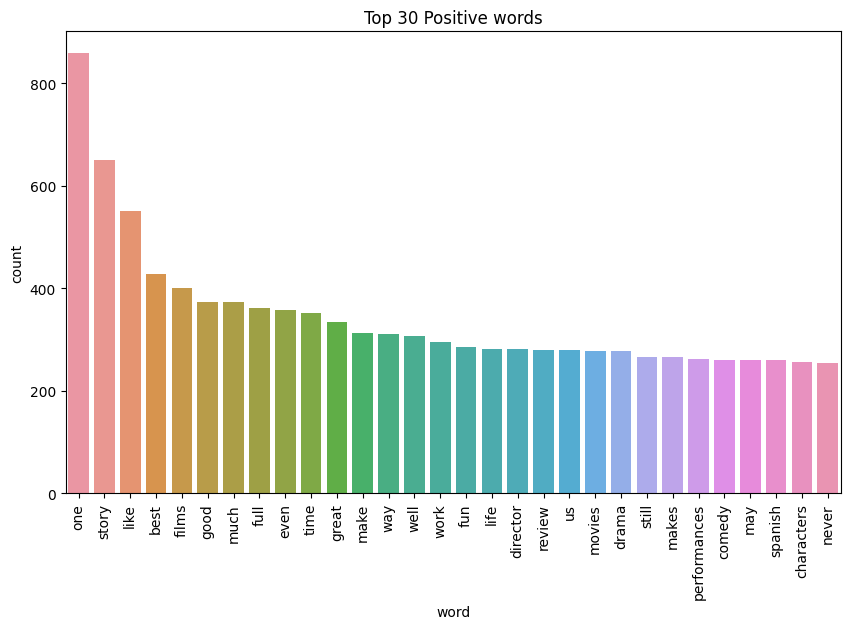

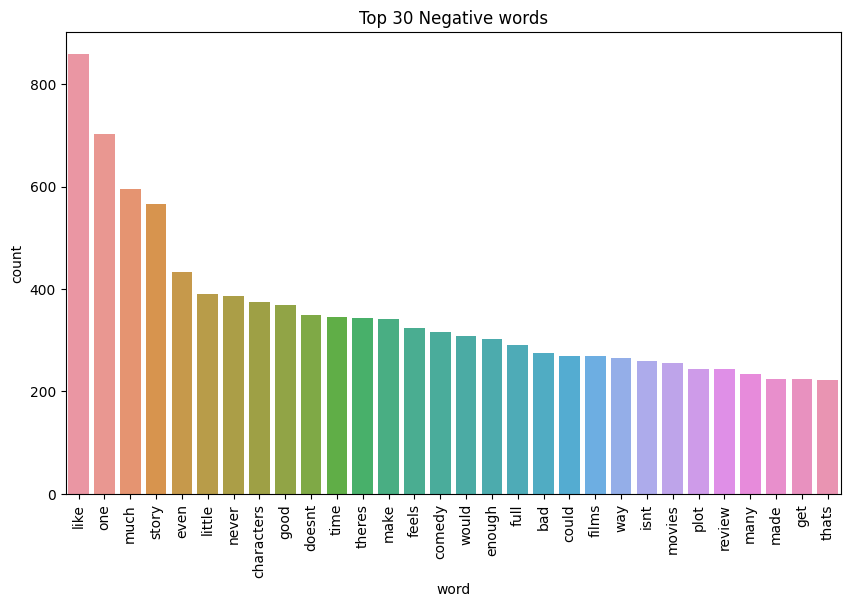

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count',
            data=df_poswords_top30, ax=ax)
plt.title("Top 30 Positive words")
plt.xticks(rotation='vertical');


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count',
            data=df_negwords_top30, ax=ax)
plt.title("Top 30 Negative words")
plt.xticks(rotation='vertical');

###2.3. Split Data

In [ ]:
# Split the data into training and testing sets
train_df, test_df, label_train, label_test = train_test_split(df['reviewText'], df['label'], test_size=0.2, random_state=42)

###2.4. Tokenization, Bag of Words, TF-IDF

In [ ]:
# Building the vocabulary on the training set
bow_transformer = CountVectorizer(analyzer=remove_punctuation_and_stopwords).fit(train_df)

# Size of the vocabulary that has learned
print(len(bow_transformer.vocabulary_))

# Convert the text data in the training set into a Bag of Words (BoW) representation
bow_train_data = bow_transformer.transform(train_df)

# Finding the number of documents (rows) and unique terms (columns) in the training set
print("Number of training documents and unique terms: ", bow_train_data.shape)

# Convert the text data in the testing set into a Bag of Words (BoW) representation
bow_test_data = bow_transformer.transform(test_df)

# Finding the number of documents (rows) and unique terms (columns) in the testing set
print("Number of testing documents and unique terms: ", bow_test_data.shape)

30380
Number of training documents and unique terms:  (16000, 30380)
Number of testing documents and unique terms:  (4000, 30380)


In [ ]:
# Convert using tf-idf on the training set
tfidf_transformer = TfidfTransformer().fit(bow_train_data)
tfidf_train_data = tfidf_transformer.transform(bow_train_data)

# Convert using tf-idf on the testing set
tfidf_test_data = tfidf_transformer.transform(bow_test_data)

In [ ]:
# finding the number of documents(rows) and unique terms(columns)
print("Number of documents and unique terms in training data: ", tfidf_train_data.shape)

# Finding the number of documents (rows) and unique terms (columns) in test data
print("Number of documents and unique terms in test data: ", tfidf_test_data.shape)

# find the count of non-zero elements in the matrix
print("Number of non-zero elements in the train matrix: ", tfidf_train_data.nnz)

# find the count of non-zero elements in the matrix in test data
print("Number of non-zero elements in the test matrix: ", tfidf_test_data.nnz)

# Calculate the percentage of how sparse the matrix is
print("Sparsity of the train matrix: ", tfidf_train_data.nnz / (tfidf_train_data.shape[0] * tfidf_train_data.shape[1]) *100 ,"%")

# Calculate the percentage of how sparse the matrix is in test data
print("Sparsity of the test matrix: ", tfidf_test_data.nnz / (tfidf_test_data.shape[0] * tfidf_test_data.shape[1]) *100 ,"%")

Number of documents and unique terms in training data:  (16000, 30380)
Number of documents and unique terms in test data:  (4000, 30380)
Number of non-zero elements in the train matrix:  195062
Number of non-zero elements in the test matrix:  44739
Sparsity of the train matrix:  0.040129608294930876 %
Sparsity of the test matrix:  0.03681616194865043 %


##3. Classification

### 3. 1. Random Forest

####Before Tuning

In [ ]:
# Create and train the Random Forest model
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(tfidf_train_data, label_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions on the training and testing set
rf_train_prediction = random_forest_classifier.predict(tfidf_train_data)
rf_test_prediction = random_forest_classifier.predict(tfidf_test_data)

In [ ]:
# Accuracy scores
rf_train_accuracy = accuracy_score(label_train, rf_train_prediction)*100
rf_test_accuracy = accuracy_score(label_test, rf_test_prediction)*100

# Confusion matrix and classification report
rf_conf_matrix = confusion_matrix(label_test, rf_test_prediction)
rf_classification_rep = classification_report(label_test, rf_test_prediction)

# Print results
print(f"Random Forest Training Accuracy: {rf_train_accuracy:.4f}%")
print(f"Random Forest Testing Accuracy: {rf_test_accuracy:.4f}%")
print("------------------------------")
print("Random Forest Confusion Matrix:\n", rf_conf_matrix)
print("Random Forest Classification Report:\n", rf_classification_rep)

Random Forest Training Accuracy: 99.9750%
Random Forest Testing Accuracy: 71.1500%
------------------------------
Random Forest Confusion Matrix:
 [[1336  719]
 [ 435 1510]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.70      2055
           1       0.68      0.78      0.72      1945

    accuracy                           0.71      4000
   macro avg       0.72      0.71      0.71      4000
weighted avg       0.72      0.71      0.71      4000



####After Tuning

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
}

# Create GridSearchCV object
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=10, scoring='accuracy')

# Fit the grid search to the data
grid_rf.fit(tfidf_train_data, label_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_rf.best_params_)

Best Parameters: {'max_depth': None, 'n_estimators': 150}


In [ ]:
random_forest_classifier_tuned = RandomForestClassifier(n_estimators=grid_rf.best_params_['n_estimators'],
                                                        max_depth=grid_rf.best_params_['max_depth'],)
random_forest_classifier_tuned.fit(tfidf_train_data, label_train)

RandomForestClassifier(n_estimators=150)

In [ ]:
# Predictions on the training and testing set
rf_train_prediction_tuned = random_forest_classifier_tuned.predict(tfidf_train_data)
rf_test_prediction_tuned = random_forest_classifier_tuned.predict(tfidf_test_data)

In [ ]:
# Accuracy scores
rf_train_accuracy_tuned = accuracy_score(label_train, rf_train_prediction_tuned)*100
rf_test_accuracy_tuned = accuracy_score(label_test, rf_test_prediction_tuned)*100

# Confusion matrix and classification report
rf_conf_matrix_tuned = confusion_matrix(label_test, rf_test_prediction_tuned)
rf_classification_rep_tuned = classification_report(label_test, rf_test_prediction_tuned)

# Print results
print(f"Random Forest Training Accuracy: {rf_train_accuracy_tuned:.4f}%")
print(f"Random Forest Testing Accuracy: {rf_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Random Forest Confusion Matrix:\n", rf_conf_matrix_tuned)
print("Random Forest Classification Report:\n", rf_classification_rep_tuned)

Random Forest Training Accuracy: 99.9750%
Random Forest Testing Accuracy: 70.8000%
------------------------------
Random Forest Confusion Matrix:
 [[1343  712]
 [ 456 1489]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.70      2055
           1       0.68      0.77      0.72      1945

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000



### 3. 2. Naive Bayes Classification

####Before Tuning

In [ ]:
df_tfidf_train_nb = tfidf_train_data.A
df_tfidf_test_nb = tfidf_test_data.A

In [ ]:
naive_bayes_classifier = MultinomialNB().fit(df_tfidf_train_nb, label_train)
nb_test_prediction = naive_bayes_classifier.predict(df_tfidf_test_nb)
nb_train_prediction = naive_bayes_classifier.predict(df_tfidf_train_nb)

In [ ]:
nb_train_accuracy = accuracy_score(label_train, nb_train_prediction)*100
nb_test_accuracy = accuracy_score(label_test, nb_test_prediction)*100

nb_conf_matrix = confusion_matrix(label_test, nb_test_prediction)
nb_classification_rep = classification_report(label_test, nb_test_prediction)

print(f"Training Accuracy: {nb_train_accuracy:.4f}%")
print(f"Testing Accuracy: {nb_test_accuracy:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", nb_conf_matrix)
print("Classification Report:\n", nb_classification_rep)

Training Accuracy: 91.5062%
Testing Accuracy: 75.6250%
------------------------------
Confusion Matrix:
 [[1530  525]
 [ 450 1495]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76      2055
           1       0.74      0.77      0.75      1945

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



####After Tuning

In [ ]:
# Define the hyperparameter grid
param_grid_nb = {'alpha': [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]}

# Create the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

# Perform grid search with cross-validation
grid_nb= GridSearchCV(naive_bayes_classifier, param_grid_nb, cv=10, scoring='accuracy')
grid_nb.fit(tfidf_train_data, label_train)

# Get the best hyperparameter values
best_alpha = grid_nb.best_params_['alpha']

print(f"Best Aplha: {best_alpha}")

Best Aplha: 3.0


In [ ]:
naive_bayes_classifier_tuned = MultinomialNB(alpha=best_alpha).fit(tfidf_train_data, label_train)

nb_test_predictions_tuned = naive_bayes_classifier_tuned.predict(tfidf_test_data)
nb_train_prediction_tuned = naive_bayes_classifier_tuned.predict(tfidf_train_data)

In [ ]:
nb_train_accuracy_tuned = accuracy_score(label_train, nb_train_prediction_tuned)*100
nb_test_accuracy_tuned = accuracy_score(label_test, nb_test_predictions_tuned)*100

nb_conf_matrix_tuned = confusion_matrix(label_test, nb_test_predictions_tuned)
nb_classification_rep_tuned = classification_report(label_test, nb_test_predictions_tuned)

print(f"Tuned Training Accuracy: {nb_train_accuracy_tuned:.4f}%")
print(f"Tuned Testing Accuracy: {nb_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Tuned_Confusion Matrix:\n", nb_conf_matrix_tuned)
print("Tuned_Classification Report:\n", nb_classification_rep_tuned)

Tuned Training Accuracy: 88.5000%
Tuned Testing Accuracy: 76.2000%
------------------------------
Tuned_Confusion Matrix:
 [[1539  516]
 [ 436 1509]]
Tuned_Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76      2055
           1       0.75      0.78      0.76      1945

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [ ]:
# Get the feature names from the CountVectorizer
feature_names = bow_transformer.get_feature_names_out()

# Get the log probabilities of features
log_probabilities = naive_bayes_classifier_tuned.feature_log_prob_[1]

# Create a DataFrame with feature names and their log probabilities
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Log Probability': log_probabilities})

# Get the top 30 negative words
negative_words_top30 = df_negwords_top30['word'].tolist()

# Filter the feature importance DataFrame to include only the top 30 negative words
filtered_feature_importance_df = feature_importance_df[feature_importance_df['Feature'].isin(negative_words_top30)]

# Sort the filtered DataFrame by log probabilities to get the most important features
filtered_feature_importance_df = filtered_feature_importance_df.sort_values(by='Log Probability', ascending=False)

# Print the top N important features
top_n = 30  # Change this to the desired number of top features
print(f"Top {top_n} Important Features:")
print(filtered_feature_importance_df.head(top_n))

Top 30 Important Features:
          Feature  Log Probability
15550        like        -7.063088
17607        much        -7.255012
18706         one        -7.258199
25648       story        -7.408007
15662      little        -7.548218
18076       never        -7.604016
9066         even        -7.609959
11365        good        -7.632323
7713       doesnt        -7.656162
26906      theres        -7.661147
4475   characters        -7.661834
5240       comedy        -7.707377
9785        feels        -7.729459
2188          bad        -7.731491
16178        make        -7.735243
27140        time        -7.771080
29942       would        -7.781888
10718        full        -7.801591
8782       enough        -7.810044
14097        isnt        -7.846526
22353      review        -7.870795
5931        could        -7.905123
29286         way        -7.941033
20159        plot        -7.953544
17583      movies        -7.975203
9953        films        -8.007119
16097        made        -8.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_negative_words = df_negwords_top30['word'].head(10).tolist()

# Create a binary dataset for association rule mining
binary_data = df['reviewText'].apply(lambda x: [1 if word in x else 0 for word in top_negative_words])
binary_data = pd.DataFrame(binary_data.tolist(), columns=top_negative_words)

# Apply Apriori algorithm
frequent_itemsets = apriori(binary_data, min_support=0.01, use_colnames=True)

# Generate association rules
association_rules_df = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Display the association rules
print("Association Rules:")
print(association_rules_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Association Rules:
  antecedents consequents  antecedent support  consequent support  support  \
0      (like)       (one)             0.07525              0.1468  0.01390   
1     (story)       (one)             0.07625              0.1468  0.01195   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.184718  1.258294  0.002853    1.046509       0.221977  
1    0.156721  1.067584  0.000757    1.011765       0.068531  


/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


### 3. 3. Support Vector Machine

####Before Tuning

In [ ]:
# Create and train the SVM model
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(tfidf_train_data, label_train)

SVC()

In [ ]:
svm_train_prediction = svm_classifier.predict(tfidf_train_data)
svm_test_prediction = svm_classifier.predict(tfidf_test_data)

In [ ]:
svm_train_accuracy = accuracy_score(label_train, svm_train_prediction)*100
svm_test_accuracy = accuracy_score(label_test, svm_test_prediction)*100

svm_conf_matrix = confusion_matrix(label_test, svm_test_prediction)
svm_classification_rep = classification_report(label_test, svm_test_prediction)

print(f"Training Accuracy: {svm_train_accuracy:.4f}%")
print(f"Testing Accuracy: {svm_test_accuracy:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", svm_conf_matrix)
print("Classification Report:\n", svm_classification_rep)

Training Accuracy: 98.8438%
Testing Accuracy: 75.5500%
------------------------------
Confusion Matrix:
 [[1500  555]
 [ 423 1522]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75      2055
           1       0.73      0.78      0.76      1945

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



####After Tuning

In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10],           # Regularization parameter
    'kernel': ['linear', 'rbf', 'sigmoid'], # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
}

# Create GridSearchCV object
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=10, scoring='accuracy')

# Fit the grid search to the data
grid_svm.fit(tfidf_train_data, label_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_svm.best_params_)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Train the model with the best hyperparameters
svm_classifier_tuned = SVC(C=grid_svm.best_params_['C'], kernel=grid_svm.best_params_['kernel'], gamma=grid_svm.best_params_['gamma'])
svm_classifier_tuned.fit(tfidf_train_data, label_train)

SVC(C=1)

In [ ]:
# Make predictions
svm_train_prediction_tuned = svm_classifier_tuned.predict(tfidf_train_data)
svm_test_predictions_tuned = svm_classifier_tuned.predict(tfidf_test_data)

In [ ]:
svm_train_accuracy_tuned = accuracy_score(label_train, svm_train_prediction_tuned) * 100
svm_test_accuracy_tuned = accuracy_score(label_test, svm_test_predictions_tuned) * 100

svm_conf_matrix_tuned = confusion_matrix(label_test, svm_test_predictions_tuned)
svm_classification_rep_tuned = classification_report(label_test, svm_test_predictions_tuned)

print(f"Training Accuracy: {svm_train_accuracy_tuned:.4f}%")
print(f"Testing Accuracy: {svm_test_accuracy_tuned:.4f}%")
print("------------------------------")
print("Confusion Matrix:\n", svm_conf_matrix_tuned)
print("Classification Report:\n", svm_classification_rep_tuned)

Training Accuracy: 98.8438%
Testing Accuracy: 75.5500%
------------------------------
Confusion Matrix:
 [[1500  555]
 [ 423 1522]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75      2055
           1       0.73      0.78      0.76      1945

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



##4. Prediction

In [ ]:
# Example sentences
exp_zip = [
      'shout out to all of the casts',
      'The plot was soo great',
      'Was so great, that i want to puke']

# convert the example text data into a Bag of Words (BoW) representation.
bow_data_exp_zip = bow_transformer.transform(exp_zip)
tfidf_transformer_exp_zip = TfidfTransformer().fit(bow_data_exp_zip)
tfidf_transformer_exp_zip = tfidf_transformer_exp_zip.transform(bow_data_exp_zip)

# Predict sentiments using Naive Bayes
nb_pred_zip = naive_bayes_classifier_tuned.predict(tfidf_transformer_exp_zip)

# Predict sentiments using Random Forest
rf_pred_zip = random_forest_classifier.predict(tfidf_transformer_exp_zip)

# Predict sentiments using SVM
svm_pred_zip = svm_classifier.predict(tfidf_transformer_exp_zip)

# Print the results
for text, nb_score, rf_score, svm_score in zip(exp_zip, nb_pred_zip, rf_pred_zip, svm_pred_zip):
    print(f"Input Text: {text}")
    print(f"NB Score: {'Positive' if nb_score == 0 else 'Negative'}")
    print(f"RF Score: {'Positive' if rf_score == 0 else 'Negative'}")
    print(f"SVM Score: {'Positive' if svm_score == 0 else 'Negative'}")
    print("------------------------")

Input Text: shout out to all of the casts
NB Score: Positive
RF Score: Negative
SVM Score: Negative
------------------------
Input Text: The plot was soo great
NB Score: Negative
RF Score: Negative
SVM Score: Negative
------------------------
Input Text: Was so great, that i want to puke
NB Score: Positive
RF Score: Positive
SVM Score: Positive
------------------------


In [ ]:
# Example sentences
exp = input("Enter a sentence for sentiment analysis: ")

# convert the example text data into a Bag of Words (BoW) representation.
bow_data_exp = bow_transformer.transform([exp])
tfidf_transformer_exp = TfidfTransformer().fit(bow_data_exp)
tfidf_transformer_exp = tfidf_transformer_exp.transform(bow_data_exp)

# Predict sentiments using Naive Bayes
nb_pred = naive_bayes_classifier_tuned.predict(tfidf_transformer_exp)

# Predict sentiments using Random Forest
rf_pred = random_forest_classifier.predict(tfidf_transformer_exp)

# Predict sentiments using SVM
svm_pred = svm_classifier.predict(tfidf_transformer_exp)

# Print the results
print(f"Input Text: {exp}")
print(f"NB Score: {'Positive' if nb_pred == 0 else 'Negative'}")
print(f"RF Score: {'Positive' if rf_pred == 0 else 'Negative'}")
print(f"SVM Score: {'Positive' if svm_pred == 0 else 'Negative'}")

Enter a sentence for sentiment analysis: Don't make me watch it again
Input Text: Don't make me watch it again
NB Score: Negative
RF Score: Negative
SVM Score: Negative
